## This notebook attempts to train and validate a DCTR model paramterized by the top mass

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras
import keras.backend as K

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# Check versions
print(keras.__version__) #2.2.4

2.2.4


# Load Data

## Utilities

In [4]:
# normalize pT and center (y, phi)
# def normalize(x):
#     mask = x[:,0] > 0
#     yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
#     x[mask,1:3] -= yphi_avg
#     x[mask,0] /= x[:,0].sum()
    
def normalize(x):
    # pT values /100
    x[:,0] /= 100.
    # jet mass values /10
    x[:,3] /= 10.
    # top mass /1000
    x[:,5] /= 1000.
    pass

In [5]:
def preprocess_data(X):
    for x in X: 
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    # remap_pids(X, pid_i=4)
    return X

## Process Data

In [6]:
# Path to downloaded data from Zenodo
data_dir = '/data1/users/asuresh/DCTRFitting/'

In [7]:
train_dataset_0_x4 = np.load(data_dir + 'part_172_5_6j_x4.npy')
train_dataset_1_x4 = np.load(data_dir + 'part_varmass_6j_x4.npy')

In [8]:
X0 = train_dataset_0_x4
# shorten X1 to same length as X0   
# s.t. network sees an equal number 
# of examples from X0 and X1        

X1 = train_dataset_1_x4[0:len(X0)]

print(np.shape(X0))
print(np.shape(X1))
print(len(X1)/(len(X0)+len(X1))) # X1 percentage of training data 

(266007, 6, 6)
(266007, 6, 6)
0.5


In [9]:
# Zip uniformally sampled top mass in part_varmass_6j
# with part_172_5_6j


# for i in range(len(X1)):
#     for j in range(6):
#         X0[i, j, 4] = X1[i, j, 4]

# X0 already zipped with mT uniformally sampled

In [10]:
Y0 = np.zeros_like(X0[:,0,0])
Y1 = np.ones_like(X1[:,0,0])

In [11]:
X = np.concatenate((X0, X1), axis = 0)
X = preprocess_data(X)

Y = np.concatenate((Y0, Y1), axis = 0)
Y = to_categorical(Y, num_classes=2)

In [12]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.2, shuffle=True)

In [13]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(425612, 6, 6)
(425612, 2)
(106402, 6, 6)
(106402, 2)


# Build Model

In [14]:
# network architecture parameters
Phi_sizes = (200,200, 256)
F_sizes = (200,200, 200)

dctr = PFN(input_dim=6, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)



# Train model

In [15]:
save_label = 'TOP_DCTR'

checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', 
                                                monitor='val_loss', 
                                                verbose=2, 
                                                save_best_only=True, 
                                                mode='min')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0, 
                                              patience=10, 
                                              verbose=1, 
                                              restore_best_weights=True)

callbacks = [checkpoint, EarlyStopping]



In [16]:
# n_fail1 = 0
# n_fail2 = 0
# n_succ = 0
# iterations = 100
# for i in range(iterations):
#     print("Iteration: ", i)
    
#     K.clear_session()
#     dctr = PFN(input_dim=6, 
#            Phi_sizes=Phi_sizes, F_sizes=F_sizes,
#            summary=False)
#     lr = 1e-4 #smaller learning rate yields better precision
#     optimizer = keras.optimizers.Adam(lr=lr)
#     dctr.model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
#     history = dctr.fit(X_train, Y_train,
#                         epochs = 1,
#                         batch_size = 1000,
#                         validation_data = (X_val, Y_val),
#                         verbose = 1)
    
#     if history.history['val_loss'][0] > 10: # Fail case 1
#         n_fail1 += 1
#     elif history.history['val_loss'][0] > 2: # Fail case 2
#         n_fail2 += 1
#     else: # success
#         n_succ += 1
#         # serialize weights to HDF5
#         dctr_weights = dctr.get_weights()
#         print("Success")
            
# n_fail = n_fail1 + n_fail2

In [17]:
# n_fail = n_fail1 + n_fail2

# print("Number of initializations failed: ", n_fail, "/", iterations)
# print("Percentage of initializations failed:", (100*n_fail/iterations), "%")

# print("Number of initializations succeeded: ", n_succ, "/", iterations)
# print("Percentage of initializations succeeded:", (100*n_succ/iterations), "%")

Finish training

In [18]:
try:
    #dctr.model.set_weights(dctr_weights)
    lr = 1e-4 #smaller learning rate yields better precision
    optimizer = keras.optimizers.Adam(lr=lr)
    dctr.model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    history = dctr.fit(X_train, Y_train,
                    epochs = 100,
                    batch_size = 1000,
                    validation_data = (X_val, Y_val),
                    verbose = 1, 
                    callbacks = callbacks)
except:
    print("Model had 0 successful initializations, will not finish training")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 425612 samples, validate on 106402 samples
Epoch 1/100





425612/425612 [==============================] - 10s 23us/step - loss: 0.7453 - acc: 0.5009 - val_loss: 0.7062 - val_acc: 0.4999

Epoch 00001: val_loss improved from inf to 0.70619, saving model to ./saved_models/TOP_DCTR.h5
Epoch 2/100
425612/425612 [==============================] - 8s 19us/step - loss: 0.7034 - acc: 0.5034 - val_loss: 0.6991 - val_acc: 0.5020

Epoch 00002: val_loss improved from 0.70619 to 0.69908, saving model to ./saved_models/TOP_DCTR.h5
Epoch 3/100
425612/425612 [==============================] - 8s 19us/step - loss: 0.7020 - acc: 0.5040 - val_loss: 0.7001 - val_acc: 0.5017

Epoch 00003: val_loss did not improve from 0.69908
Epoch 4/100
425612/425612 [==============================] - 8s 19us/step - loss: 0.6997 - acc: 0.5056 - val_loss: 0.7066 - val_acc: 0.4979

Epoch 00004: val_loss did not improv

# Plot History

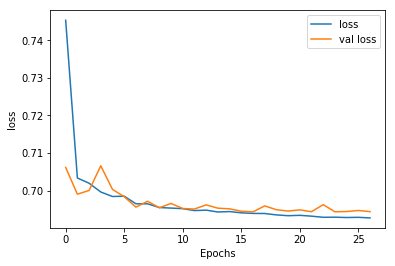

In [19]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

## Load Datasets

In [20]:
test_dataset_0 = np.load(data_dir+'part_172_5_6j.npy')
test_dataset_1 = np.load(data_dir+'part_175_0_6j.npy')

In [21]:
# Define labels for legends
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'

def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

## Get predictions

In [22]:
# Load test datasets
X0_test = test_dataset_0[:,:,:5]
X1_test = test_dataset_1[:,:,:5]



In [23]:
# Define labels for legends
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'

def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

### Define reweighting function

We must calculate two liklihood ratios during reweighting: the first because the training datasets were different sizes, and the second because the validation datasets are different sizes.

In [26]:
# Get predicted probabilities
def reweight(events, param):
    concat_input_and_params = np.ones_like(events[:,:,0:1]) * param
    model_inputs = np.concatenate((events, concat_input_and_params), axis = 2)
    model_inputs = preprocess_data(model_inputs)
    f = dctr.predict(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    return weights, model_inputs


### Get weights

In [27]:
weights_0, test = reweight(events = X0_test, param =172.5)

weights_1, _ = reweight(events = X0_test, param =175.0)

### Analyze weights

In [28]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

2.0268762
2.0403824
2.0234952
2.046422


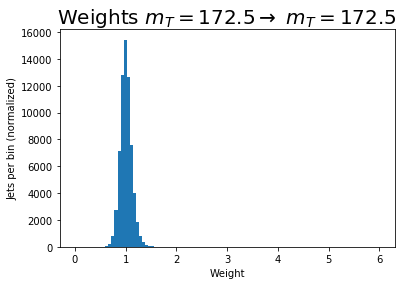

In [29]:
clip_val = 6
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_0, fontsize = 20)
plt.show()

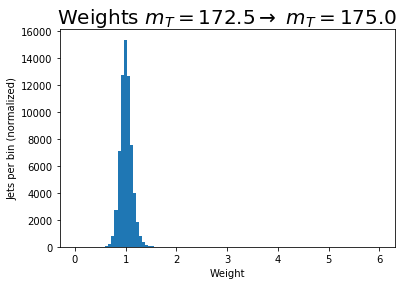

In [30]:
clip_val = 6
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_1, fontsize = 20)
plt.show()

### Validating Reweighting

In [31]:
test_obs_0 = np.load(data_dir + 'part_172_5_6j_obs.npy')
test_obs_1 = np.load(data_dir + 'part_175_0_6j_obs.npy')

In [32]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

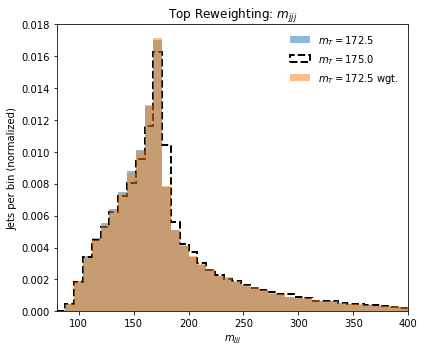

In [33]:
plt.figure(figsize=(6,5))
plt.title("Top Reweighting: $m_{jjj}$")
bins = np.linspace(80,400,41)
hist0 = plt.hist(test_obs_0[:,0], bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(test_obs_1[:,0], bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(test_obs_0[:,0], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

plt.xlabel('$m_{jjj}$')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([80,400])
make_legend()
#plt.savefig("Top Reweighting: m_{jjj} only.png")
plt.show()

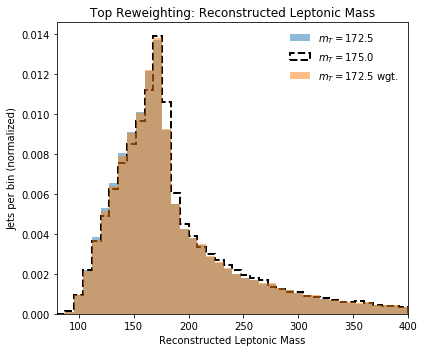

In [34]:
plt.figure(figsize=(6,5))
plt.title("Top Reweighting: Reconstructed Leptonic Mass")
bins = np.linspace(80,400,41)
hist0 = plt.hist(test_obs_0[:,1], bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(test_obs_1[:,1], bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(test_obs_0[:,1], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

plt.xlabel('Reconstructed Leptonic Mass')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([80,400])
make_legend()
#plt.savefig("Top Reweighting: m_{jjj} only.png")
plt.show()

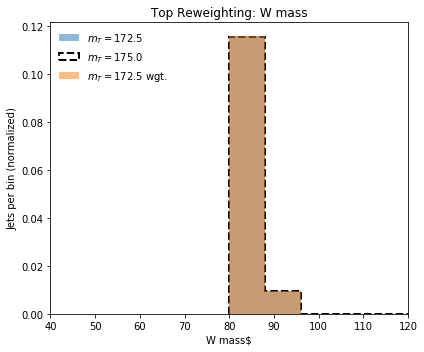

In [35]:
plt.figure(figsize=(6,5))
plt.title("Top Reweighting: W mass")
bins = np.linspace(80,400,41)
hist0 = plt.hist(test_obs_0[:,2], bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(test_obs_1[:,2], bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(test_obs_0[:,2], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

plt.xlabel('W mass$')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([40,120])
make_legend()
#plt.savefig("Top Reweighting: m_{jjj} only.png")
plt.show()

Iteration:  0
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5347 - acc: 0.7906 - val_loss: 0.5115 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5140 - acc: 0.7932 - val_loss: 0.5101 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5124 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5119 - acc: 0.7932 - val_loss: 0.5093 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/ste

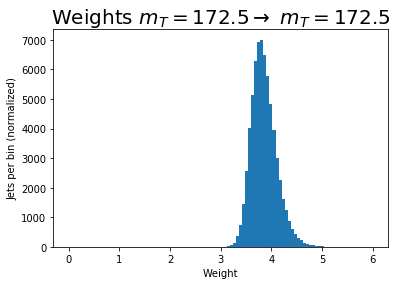

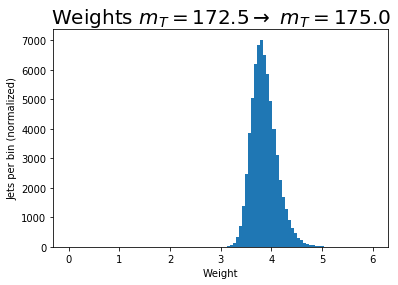

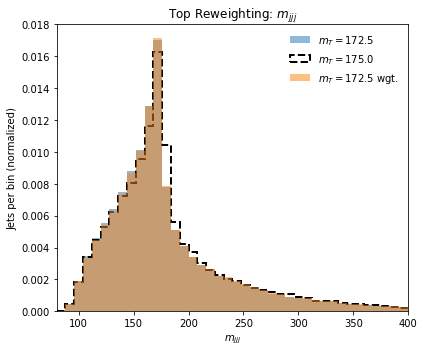

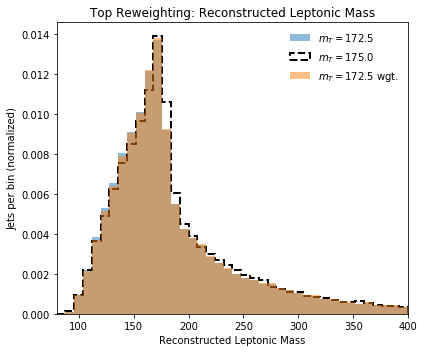

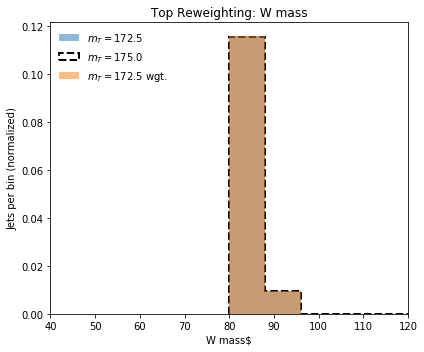

Iteration:  1
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5252 - acc: 0.7912 - val_loss: 0.5133 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5133 - acc: 0.7932 - val_loss: 0.5118 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5123 - acc: 0.7932 - val_loss: 0.5101 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5113 - acc: 0.7932 - val_loss: 0.5092 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5105 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5106 - acc: 0.7932 - val_loss: 0.5092 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/ste

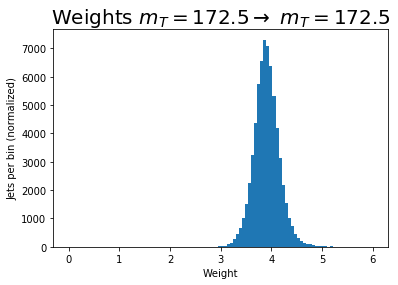

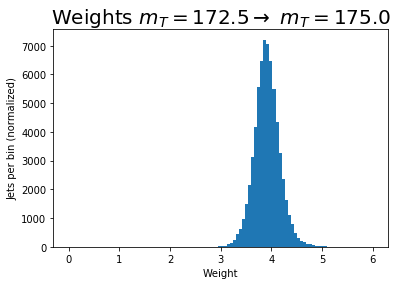

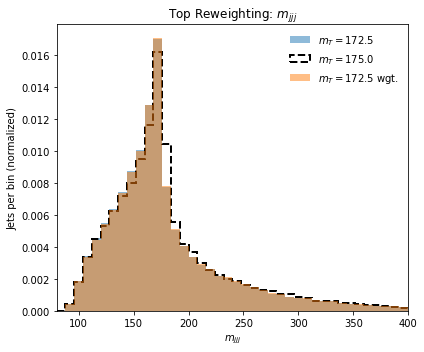

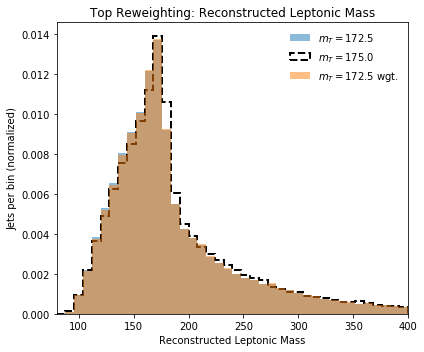

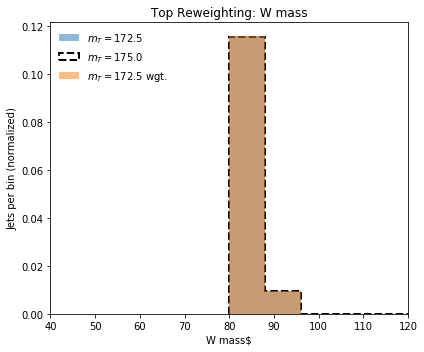

Iteration:  2
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5229 - acc: 0.7915 - val_loss: 0.5126 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5136 - acc: 0.7932 - val_loss: 0.5118 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5119 - acc: 0.7932 - val_loss: 0.5100 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5115 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5104 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/ste

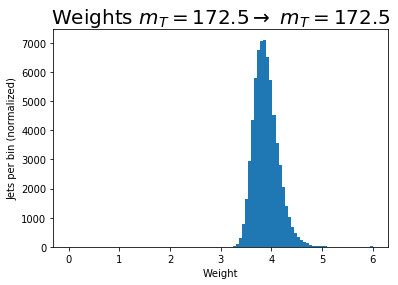

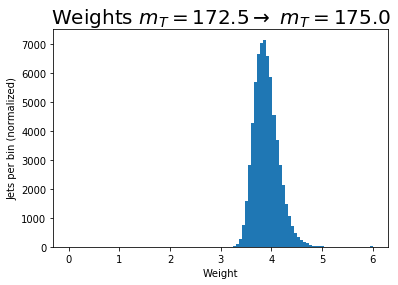

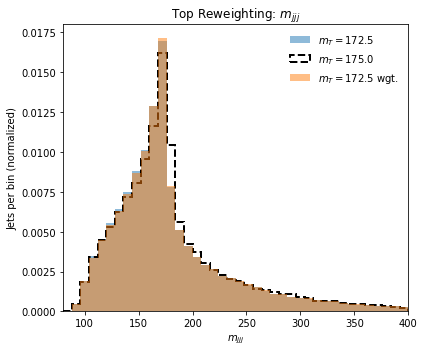

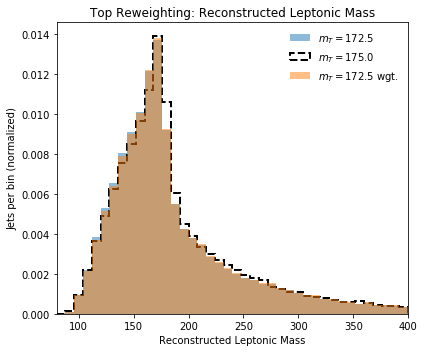

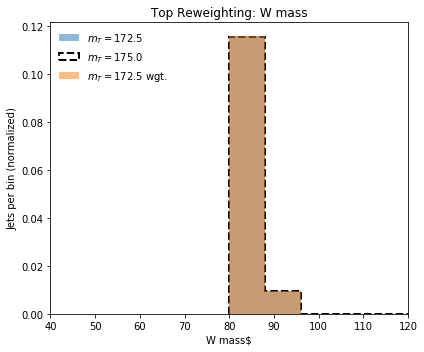

Iteration:  3
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5308 - acc: 0.7904 - val_loss: 0.5244 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5139 - acc: 0.7932 - val_loss: 0.5112 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5125 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5114 - acc: 0.7932 - val_loss: 0.5105 - val_acc: 0.7942
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/ste

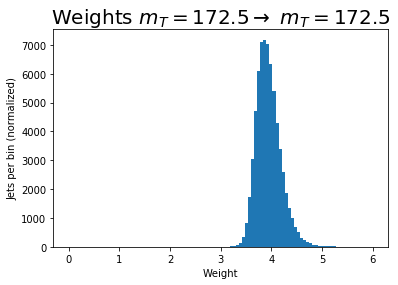

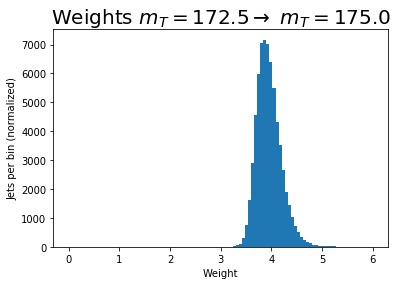

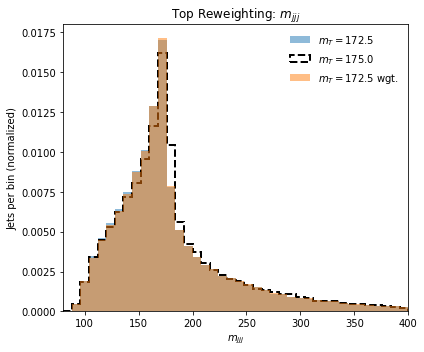

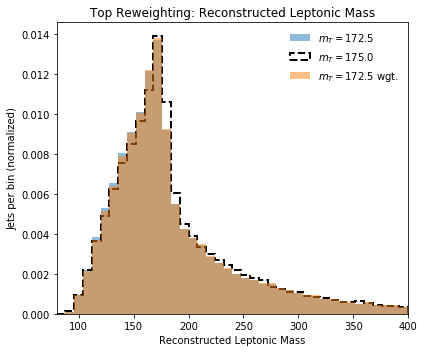

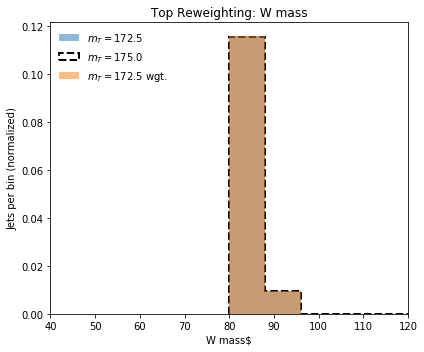

Iteration:  4
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5208 - acc: 0.7923 - val_loss: 0.5289 - val_acc: 0.7941
Epoch 2/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5136 - acc: 0.7932 - val_loss: 0.5124 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5122 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5114 - acc: 0.7932 - val_loss: 0.5092 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5086 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5103 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/ste

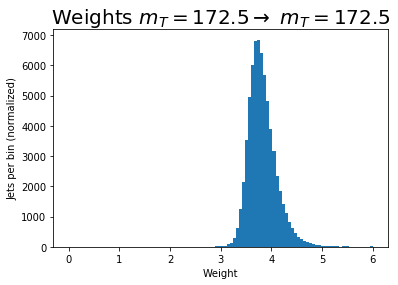

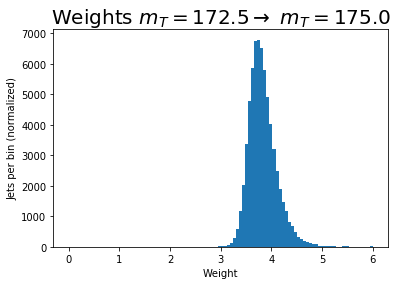

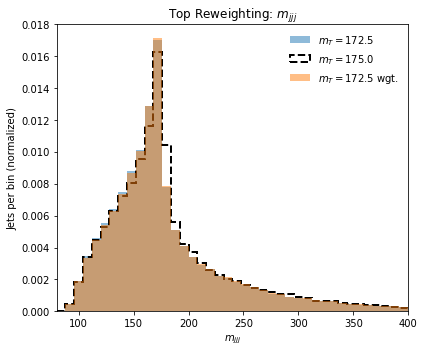

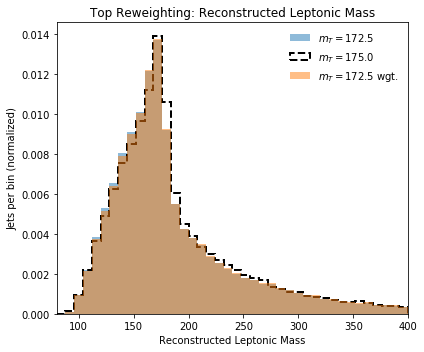

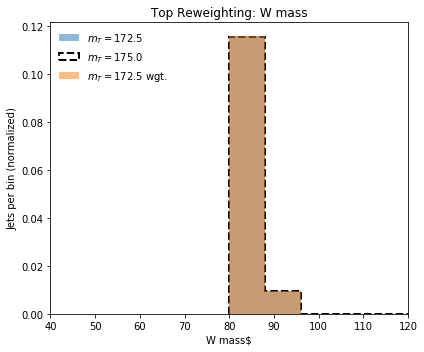

Iteration:  5
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5204 - acc: 0.7922 - val_loss: 0.5127 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5127 - acc: 0.7932 - val_loss: 0.5113 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5118 - acc: 0.7932 - val_loss: 0.5111 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5104 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/ste

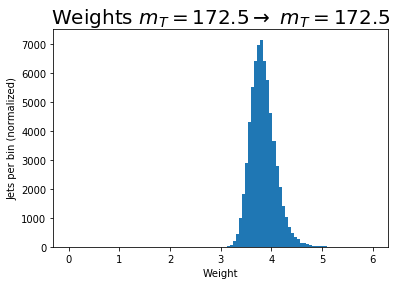

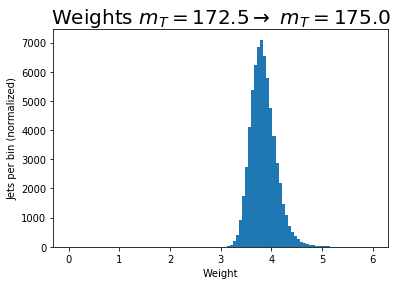

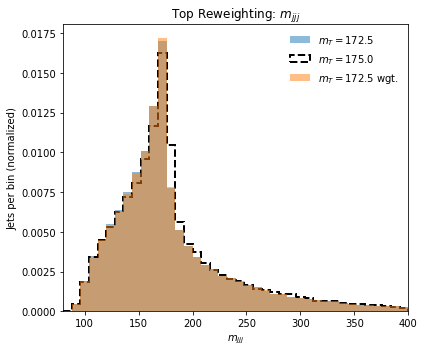

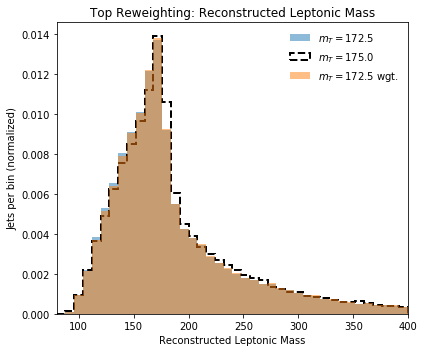

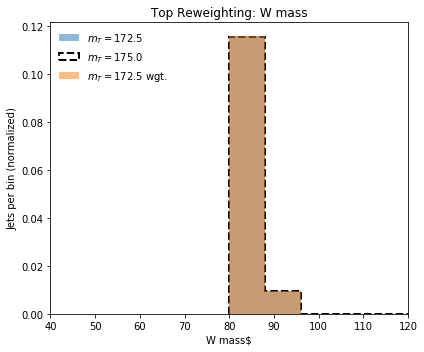

Iteration:  6
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5696 - acc: 0.7883 - val_loss: 0.5126 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5144 - acc: 0.7932 - val_loss: 0.5118 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5129 - acc: 0.7932 - val_loss: 0.5169 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5092 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/ste

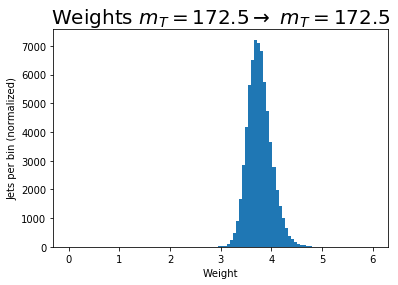

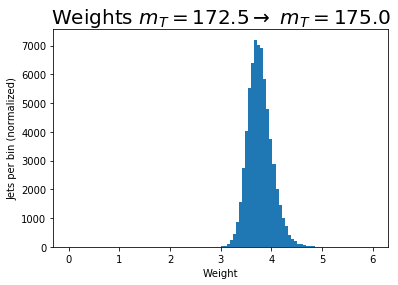

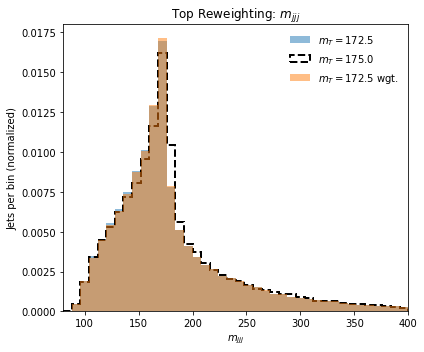

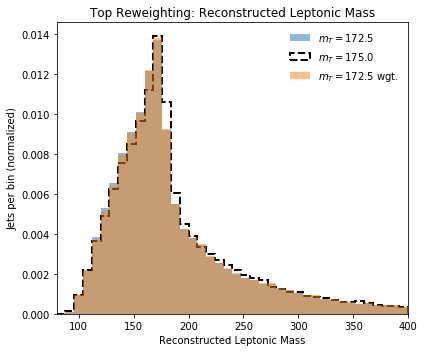

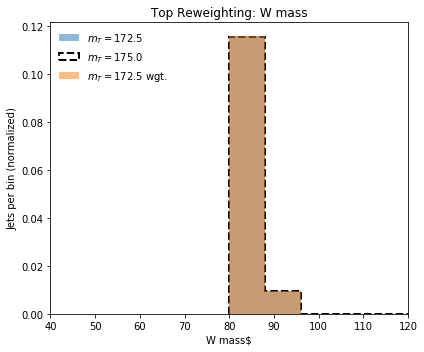

Iteration:  7
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5239 - acc: 0.7915 - val_loss: 0.5181 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5139 - acc: 0.7932 - val_loss: 0.5097 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5124 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7942
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5117 - acc: 0.7932 - val_loss: 0.5097 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5085 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5086 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/ste

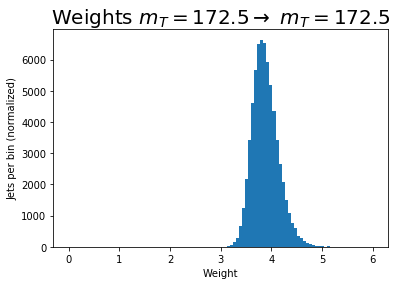

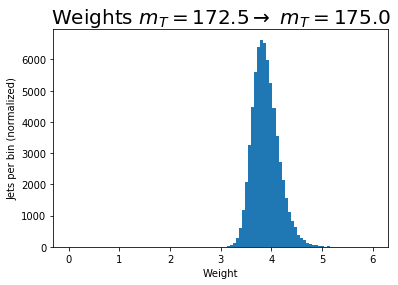

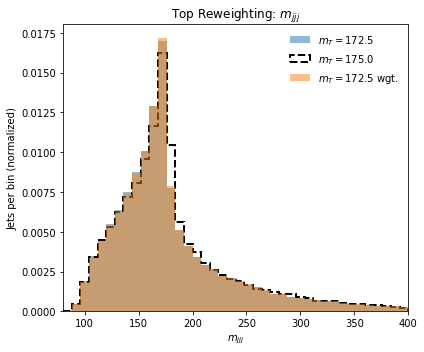

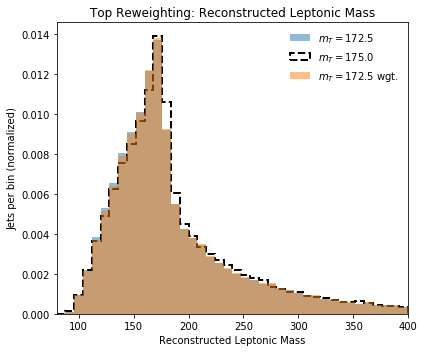

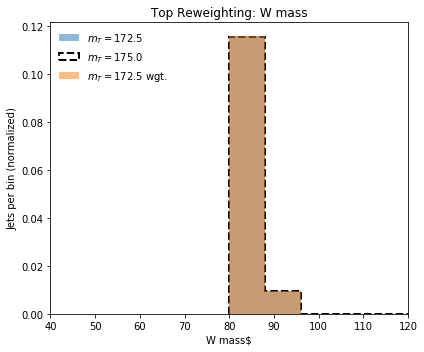

Iteration:  8
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5674 - acc: 0.7880 - val_loss: 0.5151 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5133 - acc: 0.7932 - val_loss: 0.5109 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5127 - acc: 0.7932 - val_loss: 0.5156 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5117 - acc: 0.7932 - val_loss: 0.5103 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/ste

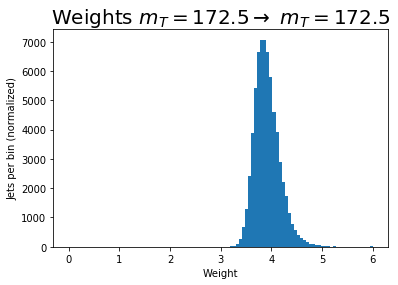

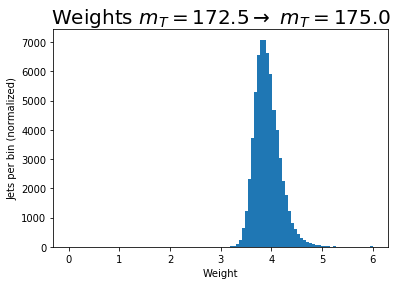

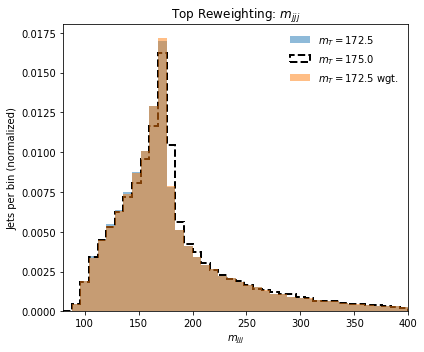

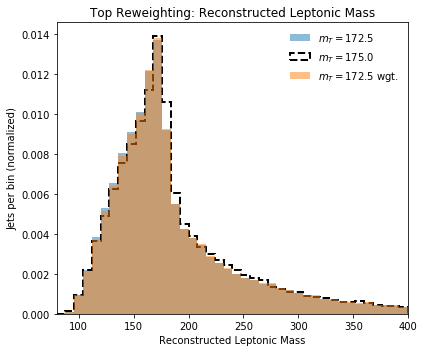

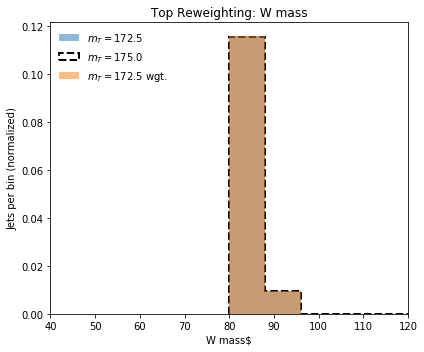

Iteration:  9
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5248 - acc: 0.7915 - val_loss: 0.5142 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5141 - acc: 0.7932 - val_loss: 0.5161 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5128 - acc: 0.7932 - val_loss: 0.5096 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5116 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5104 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5100 - val_acc: 0.7942
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/ste

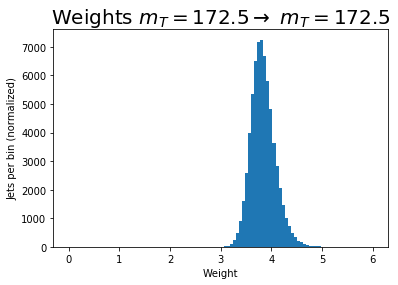

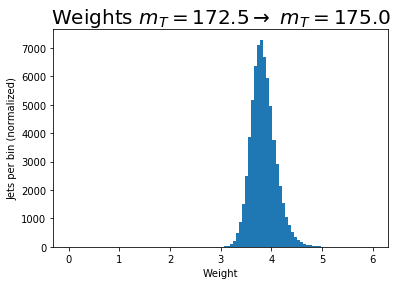

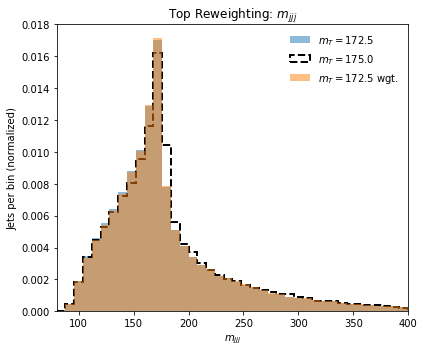

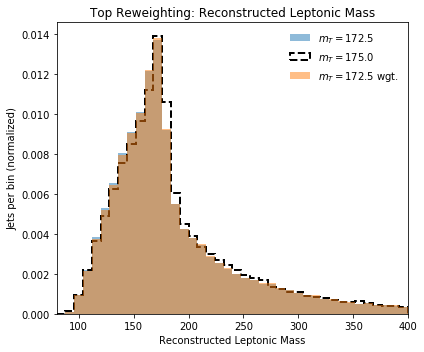

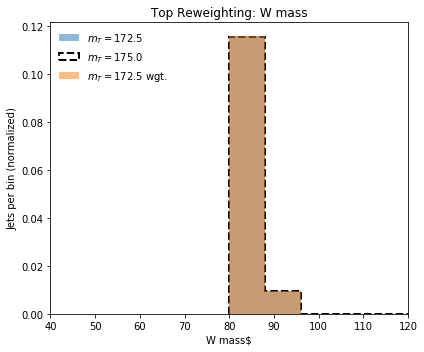

Iteration:  10
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5259 - acc: 0.7913 - val_loss: 0.5110 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5128 - acc: 0.7932 - val_loss: 0.5093 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5118 - acc: 0.7932 - val_loss: 0.5115 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5109 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5106 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

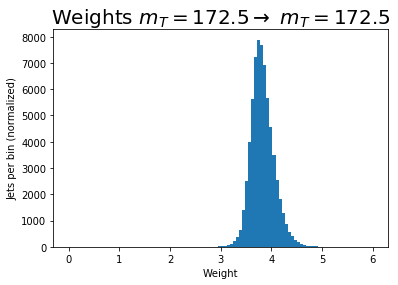

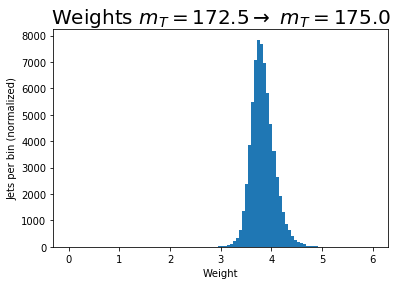

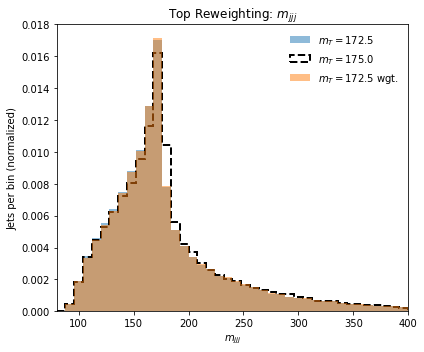

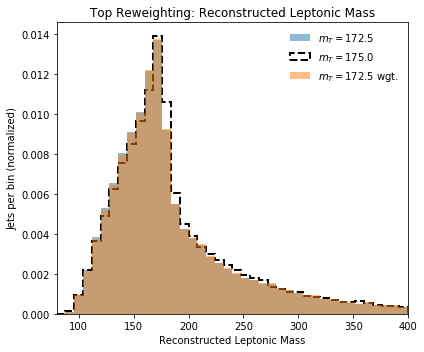

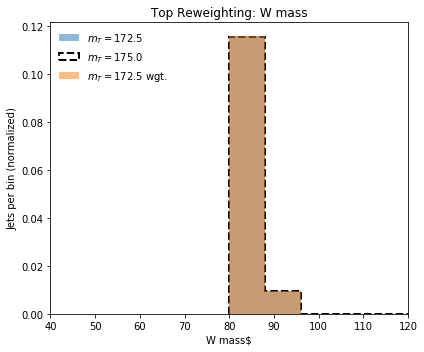

Iteration:  11
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5199 - acc: 0.7919 - val_loss: 0.5102 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5131 - acc: 0.7932 - val_loss: 0.5106 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5116 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5116 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5113 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5106 - acc: 0.7932 - val_loss: 0.5086 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

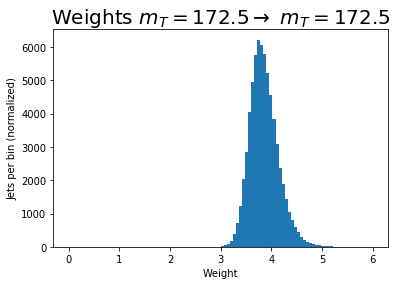

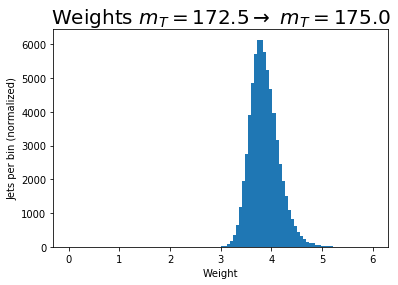

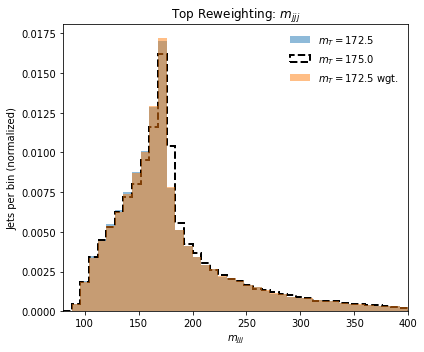

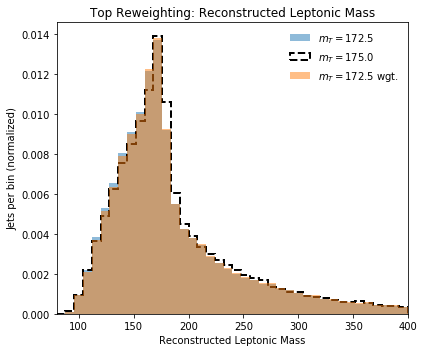

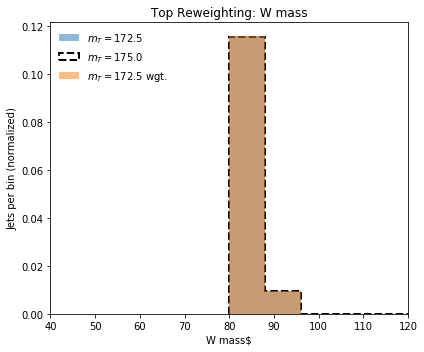

Iteration:  12
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 23s 20us/step - loss: 0.5373 - acc: 0.7898 - val_loss: 0.5148 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5141 - acc: 0.7932 - val_loss: 0.5125 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5132 - acc: 0.7932 - val_loss: 0.5125 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5111 - val_acc: 0.7942
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5116 - acc: 0.7932 - val_loss: 0.5096 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5103 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

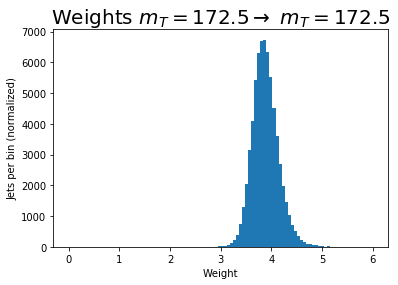

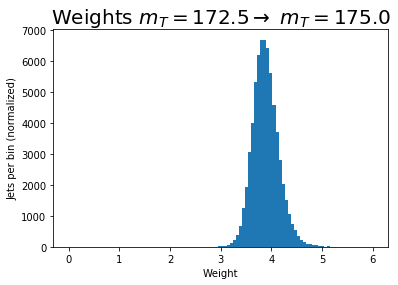

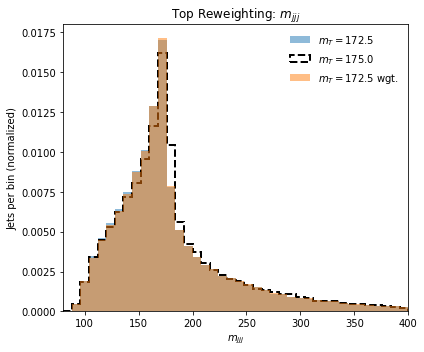

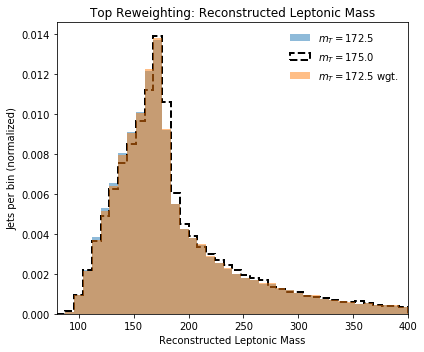

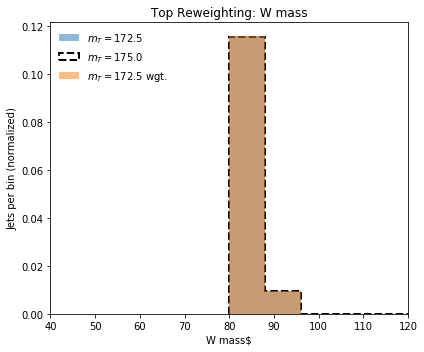

Iteration:  13
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5836 - acc: 0.7878 - val_loss: 0.5133 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5139 - acc: 0.7932 - val_loss: 0.5119 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5126 - acc: 0.7932 - val_loss: 0.5096 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5090 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5113 - acc: 0.7932 - val_loss: 0.5108 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7942
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

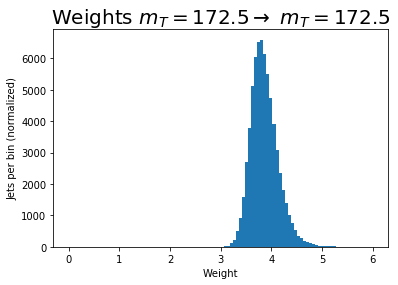

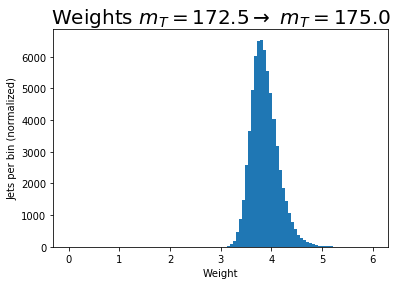

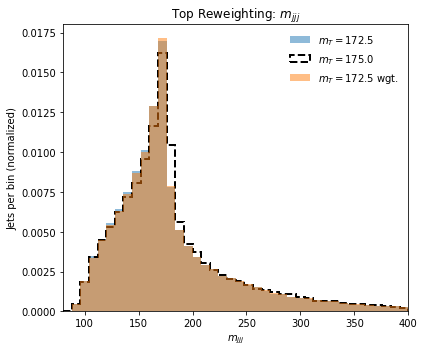

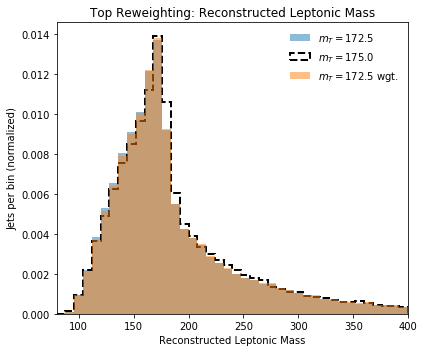

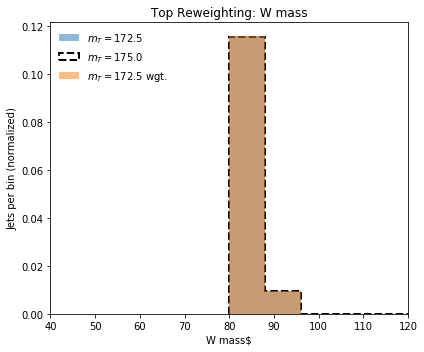

Iteration:  14
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5357 - acc: 0.7900 - val_loss: 0.5213 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5136 - acc: 0.7932 - val_loss: 0.5107 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5123 - acc: 0.7932 - val_loss: 0.5102 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5117 - acc: 0.7932 - val_loss: 0.5129 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

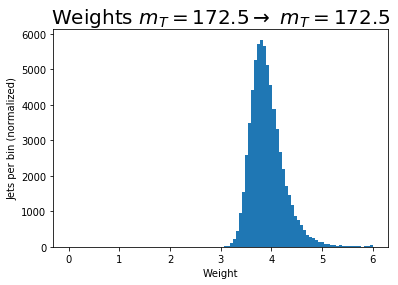

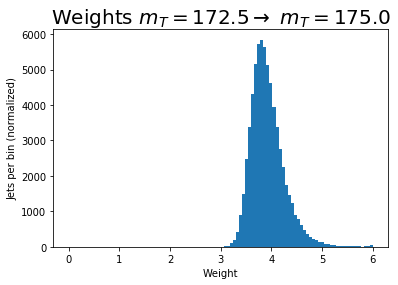

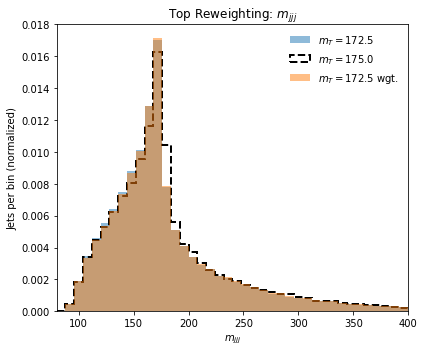

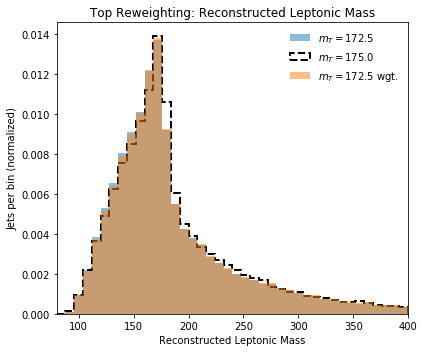

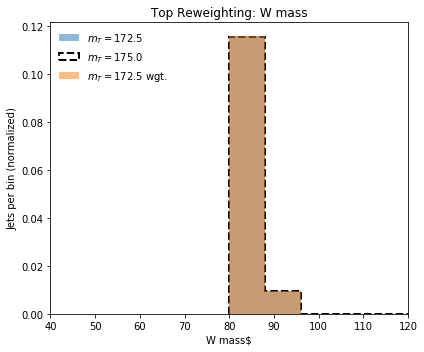

Iteration:  15
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5252 - acc: 0.7916 - val_loss: 0.5184 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5132 - acc: 0.7932 - val_loss: 0.5108 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5115 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5086 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5098 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5104 - acc: 0.7932 - val_loss: 0.5090 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

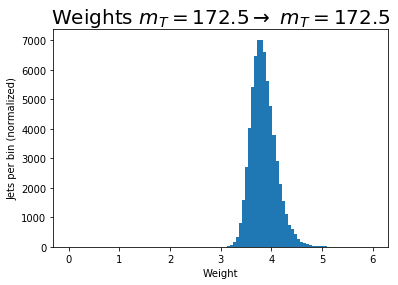

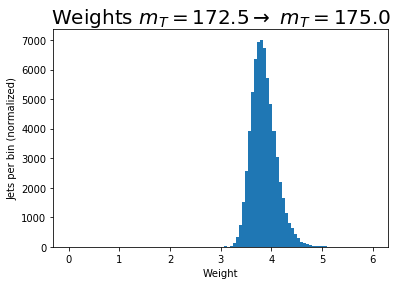

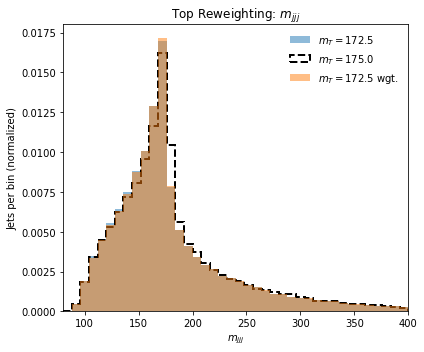

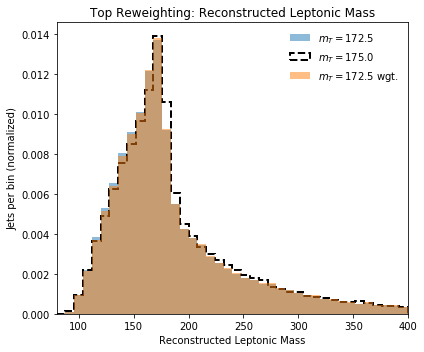

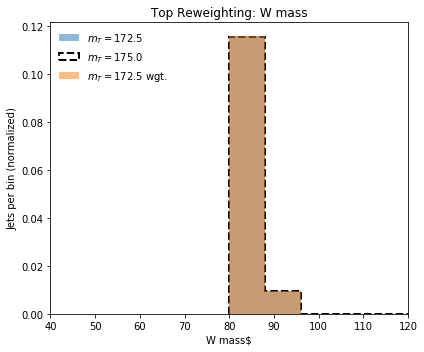

Iteration:  16
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5226 - acc: 0.7919 - val_loss: 0.5188 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5142 - acc: 0.7932 - val_loss: 0.5114 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5131 - acc: 0.7932 - val_loss: 0.5118 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5118 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

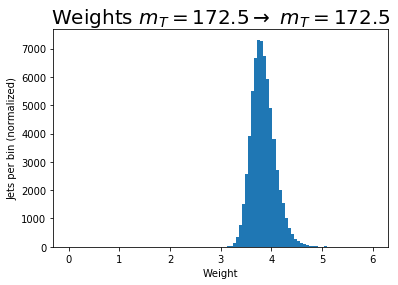

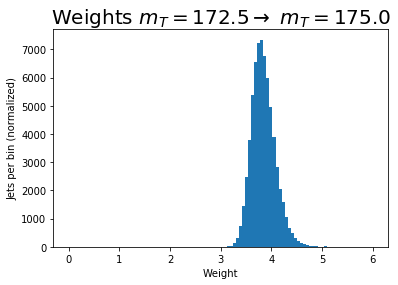

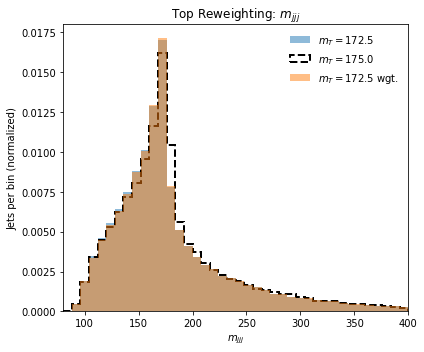

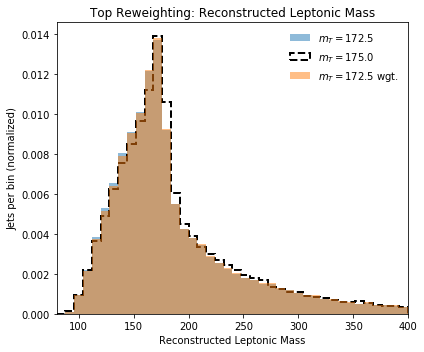

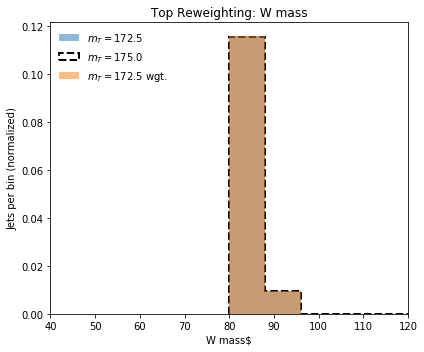

Iteration:  17
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5220 - acc: 0.7917 - val_loss: 0.5112 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5132 - acc: 0.7932 - val_loss: 0.5157 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5123 - acc: 0.7932 - val_loss: 0.5127 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5116 - acc: 0.7932 - val_loss: 0.5156 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5085 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5097 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

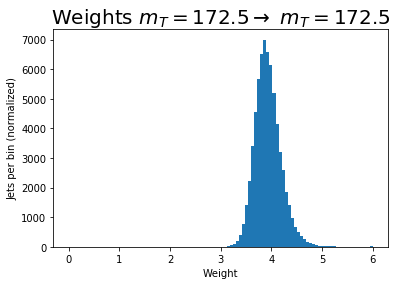

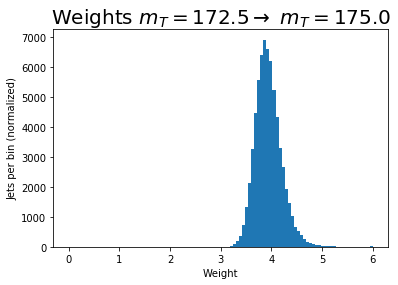

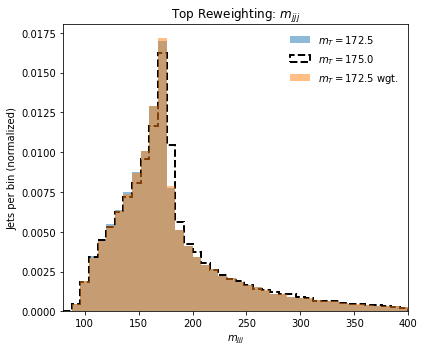

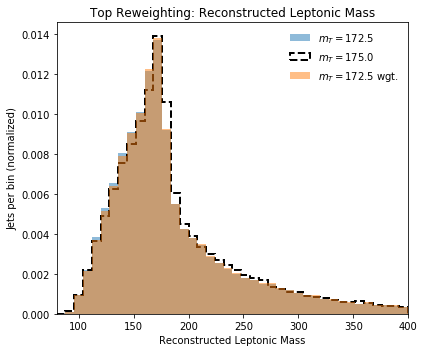

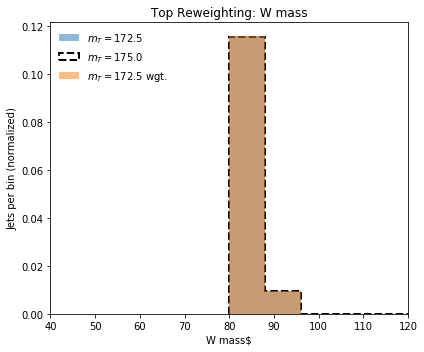

Iteration:  18
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5351 - acc: 0.7901 - val_loss: 0.5122 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5136 - acc: 0.7932 - val_loss: 0.5098 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5121 - acc: 0.7932 - val_loss: 0.5113 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5118 - acc: 0.7932 - val_loss: 0.5094 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5086 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5106 - acc: 0.7932 - val_loss: 0.5094 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

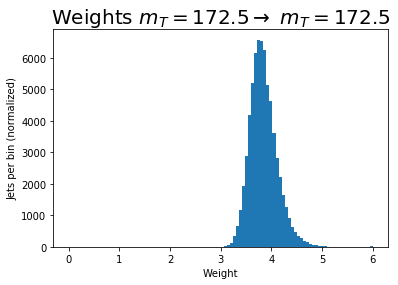

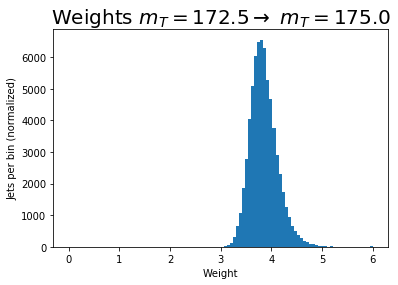

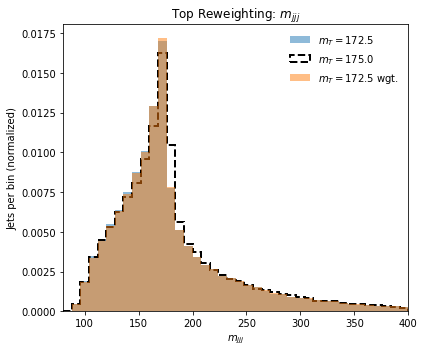

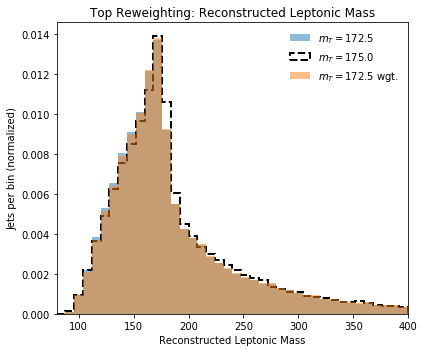

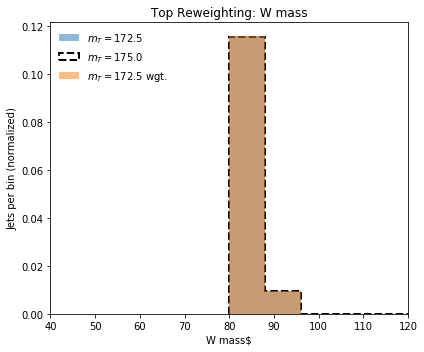

Iteration:  19
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5189 - acc: 0.7923 - val_loss: 0.5105 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5126 - acc: 0.7932 - val_loss: 0.5096 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5113 - acc: 0.7932 - val_loss: 0.5106 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5126 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5111 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

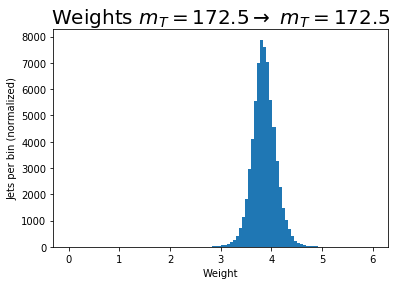

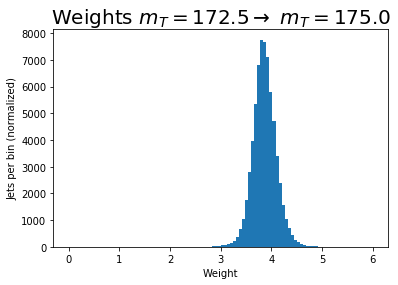

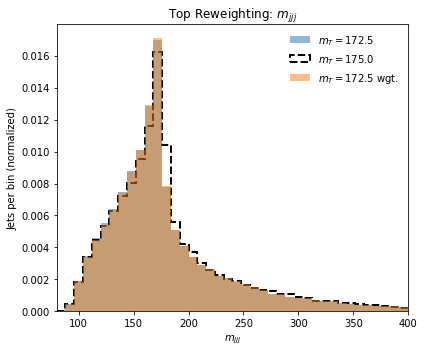

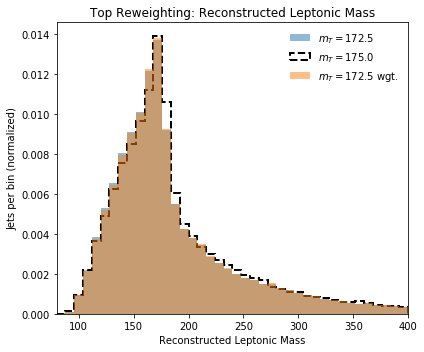

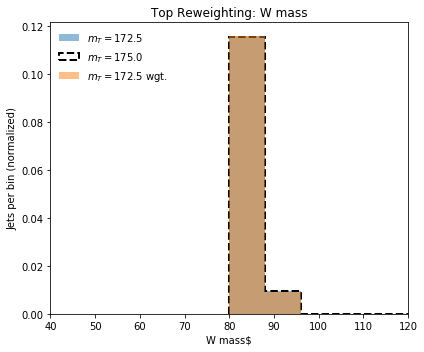

Iteration:  20
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5244 - acc: 0.7913 - val_loss: 0.5119 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5133 - acc: 0.7932 - val_loss: 0.5109 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5119 - acc: 0.7932 - val_loss: 0.5107 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5090 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5099 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5103 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

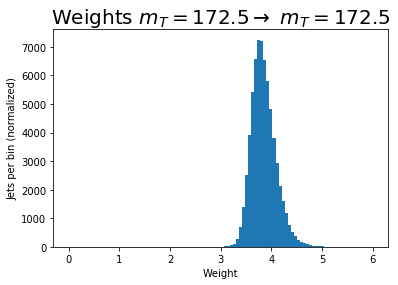

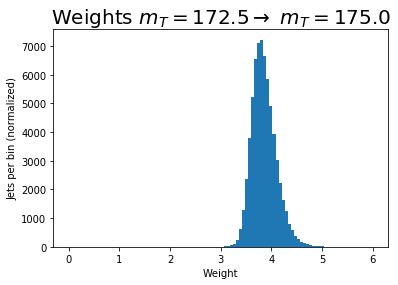

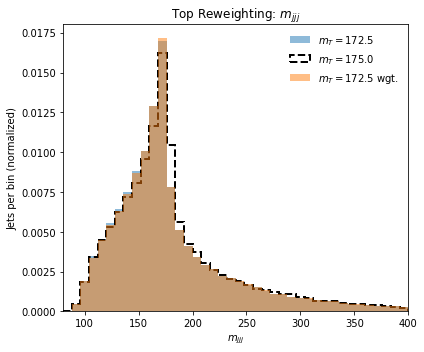

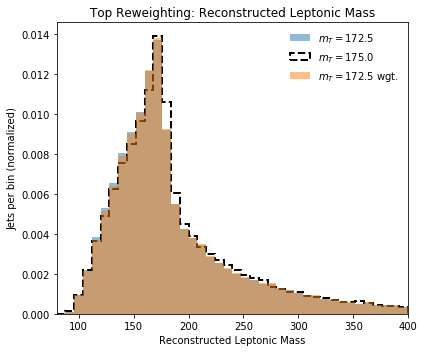

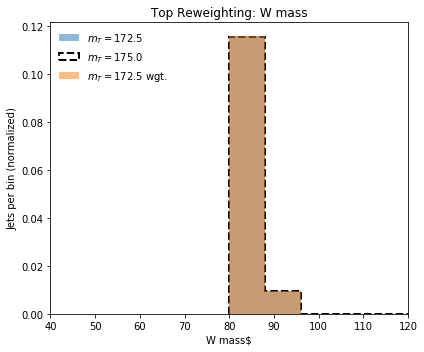

Iteration:  21
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5345 - acc: 0.7898 - val_loss: 0.5101 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5112 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5093 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5092 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5103 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

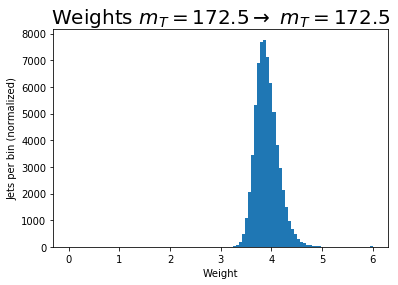

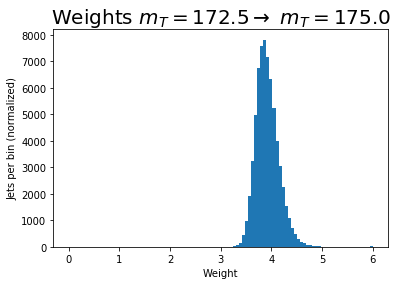

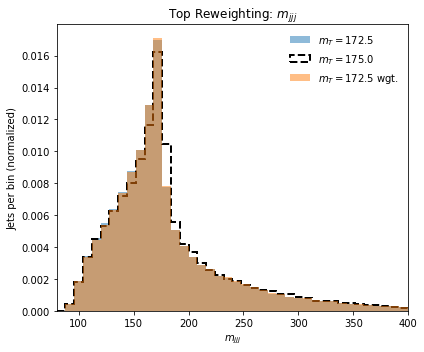

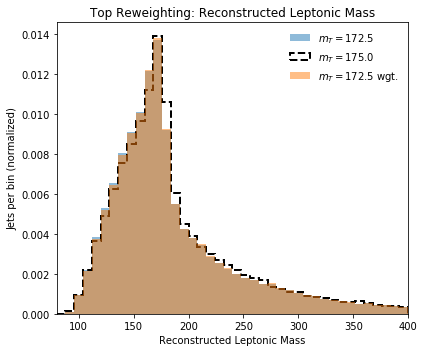

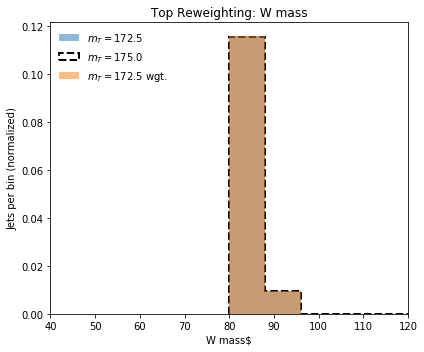

Iteration:  22
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5717 - acc: 0.7879 - val_loss: 0.5223 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5134 - acc: 0.7932 - val_loss: 0.5112 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5122 - acc: 0.7932 - val_loss: 0.5127 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5117 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

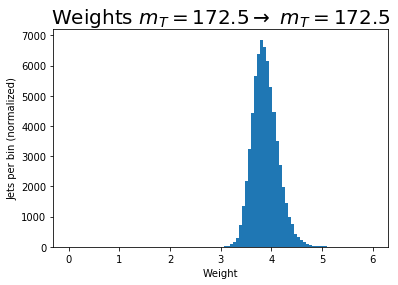

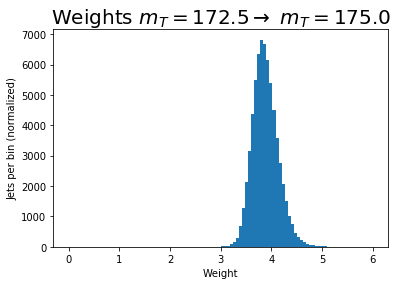

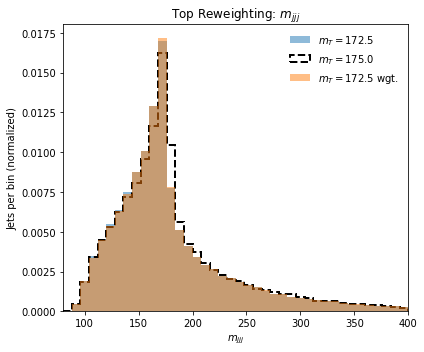

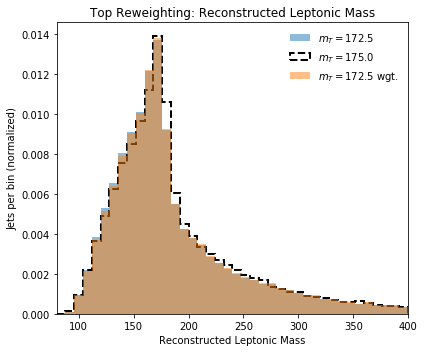

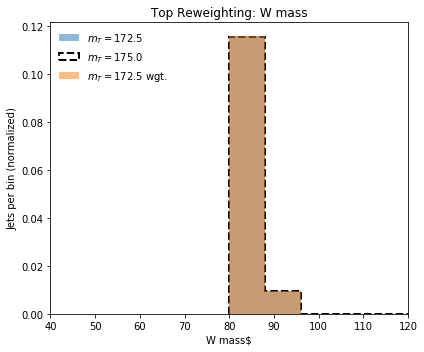

Iteration:  23
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5253 - acc: 0.7913 - val_loss: 0.5166 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5140 - acc: 0.7932 - val_loss: 0.5138 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5127 - acc: 0.7932 - val_loss: 0.5118 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5116 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5108 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/st

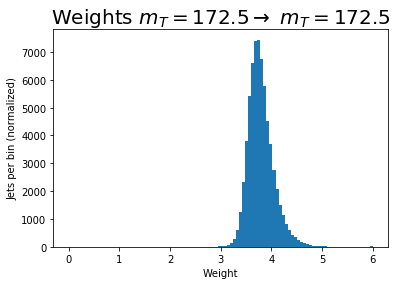

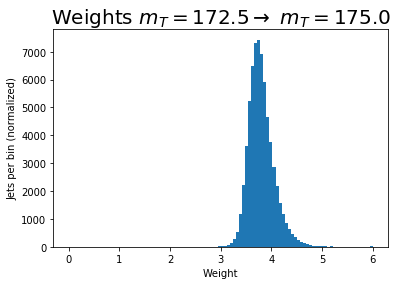

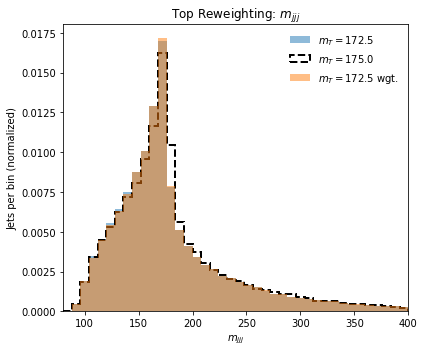

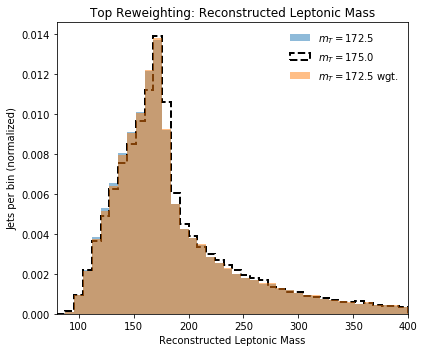

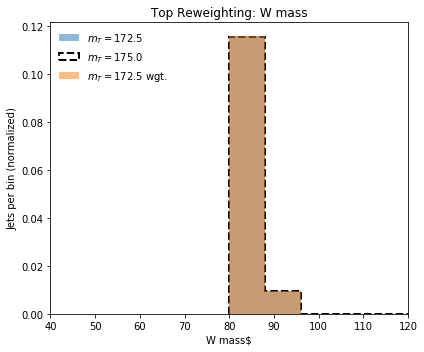

Iteration:  24
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5248 - acc: 0.7914 - val_loss: 0.5151 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5142 - acc: 0.7932 - val_loss: 0.5130 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5131 - acc: 0.7932 - val_loss: 0.5098 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5118 - acc: 0.7932 - val_loss: 0.5103 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5097 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

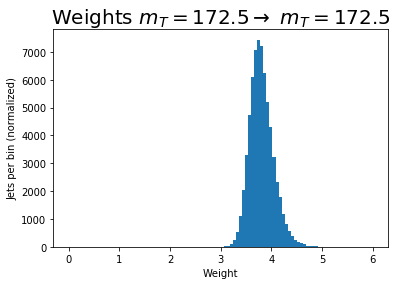

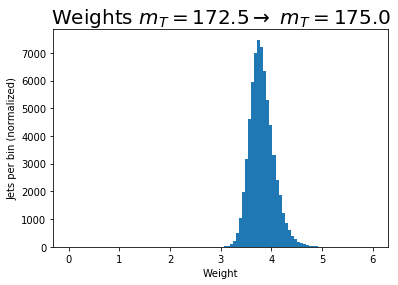

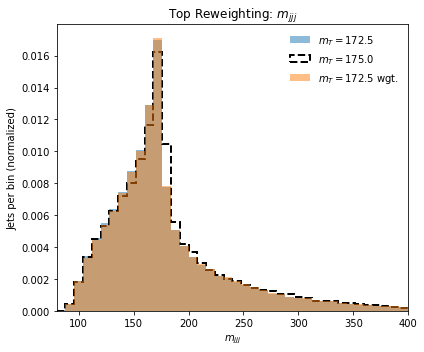

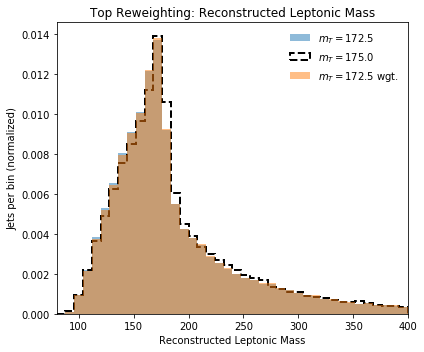

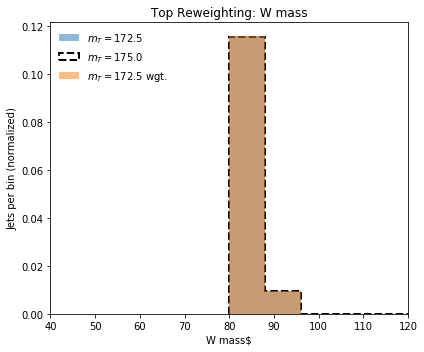

Iteration:  25
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5322 - acc: 0.7904 - val_loss: 0.5104 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5129 - acc: 0.7932 - val_loss: 0.5113 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5118 - acc: 0.7932 - val_loss: 0.5093 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5103 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/st

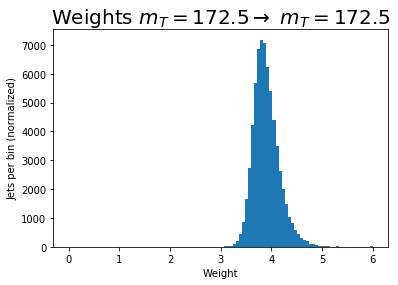

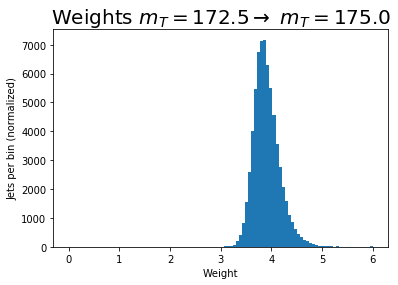

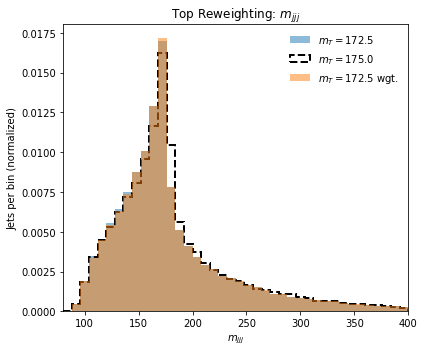

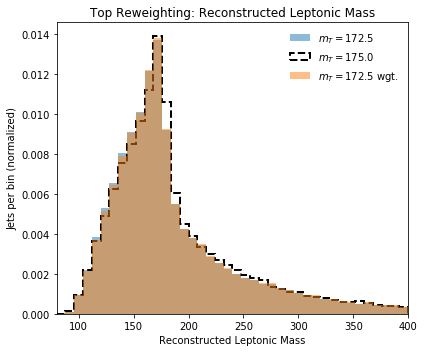

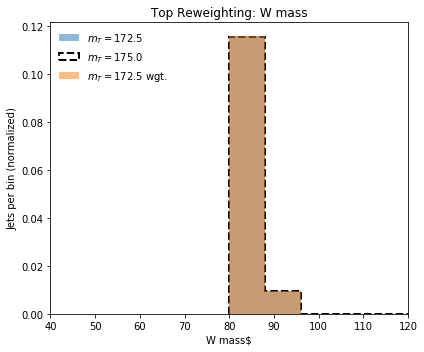

Iteration:  26
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5655 - acc: 0.7884 - val_loss: 0.5155 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5137 - acc: 0.7932 - val_loss: 0.5100 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5124 - acc: 0.7932 - val_loss: 0.5121 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5118 - acc: 0.7932 - val_loss: 0.5094 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5114 - acc: 0.7932 - val_loss: 0.5104 - val_acc: 0.7942
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

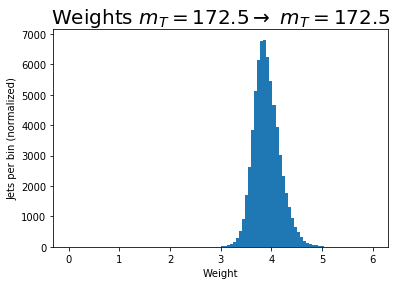

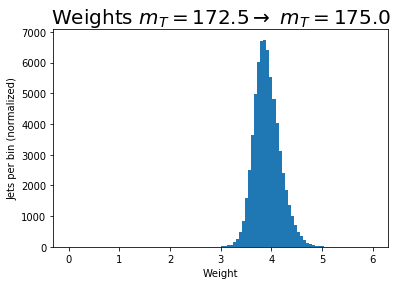

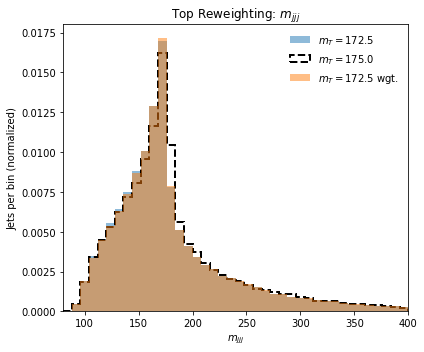

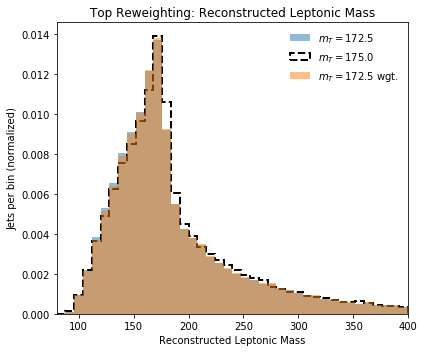

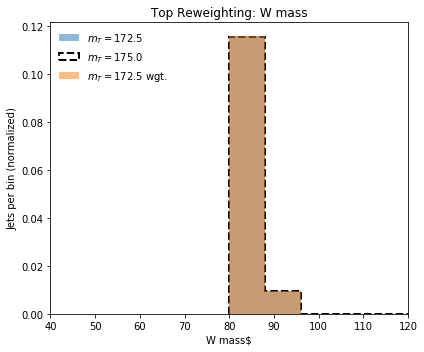

Iteration:  27
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5208 - acc: 0.7920 - val_loss: 0.5134 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5135 - acc: 0.7932 - val_loss: 0.5093 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5122 - acc: 0.7932 - val_loss: 0.5124 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5115 - acc: 0.7932 - val_loss: 0.5112 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5099 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

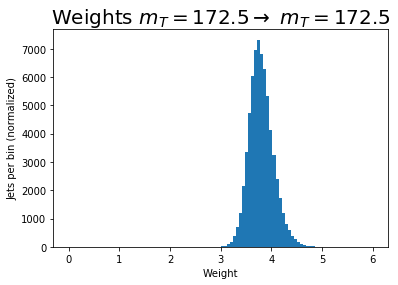

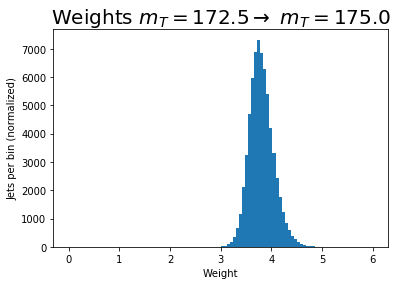

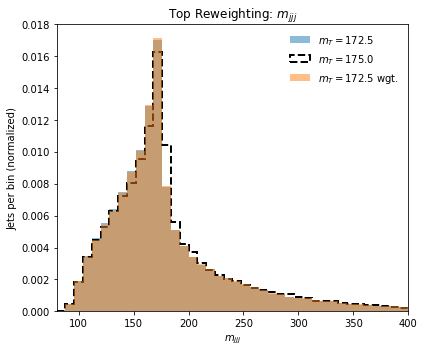

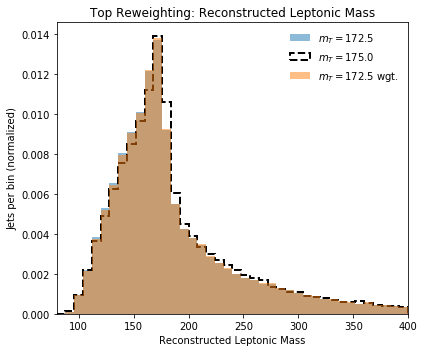

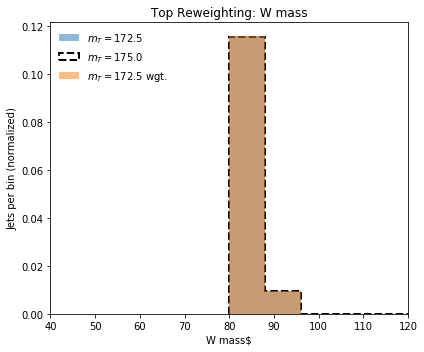

Iteration:  28
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5191 - acc: 0.7924 - val_loss: 0.5133 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5124 - acc: 0.7932 - val_loss: 0.5148 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5115 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5086 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5094 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5104 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/st

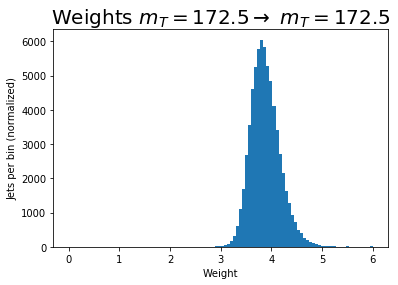

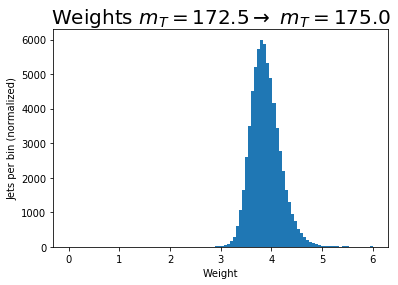

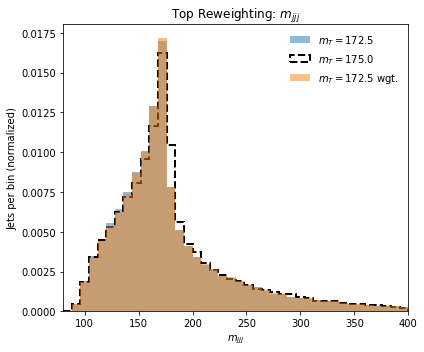

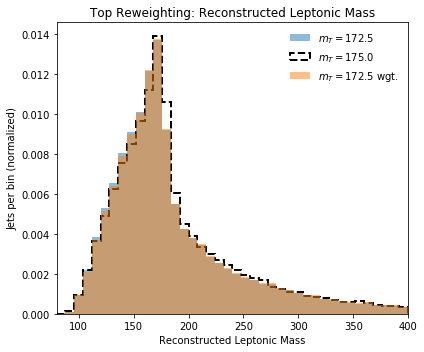

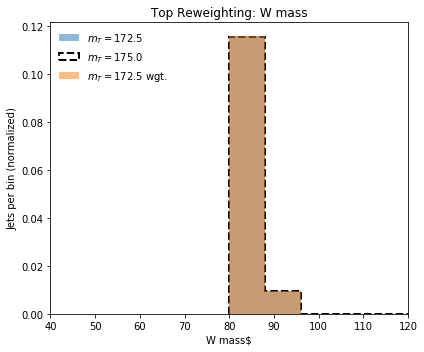

Iteration:  29
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5232 - acc: 0.7914 - val_loss: 0.5113 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5133 - acc: 0.7932 - val_loss: 0.5133 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5122 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5115 - acc: 0.7932 - val_loss: 0.5127 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5085 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5106 - acc: 0.7932 - val_loss: 0.5099 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

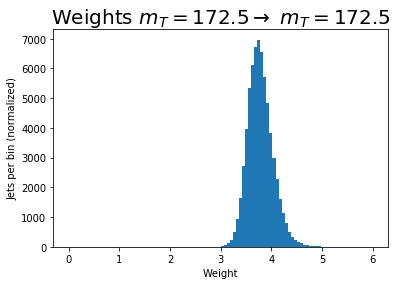

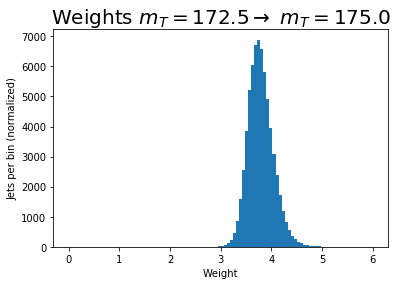

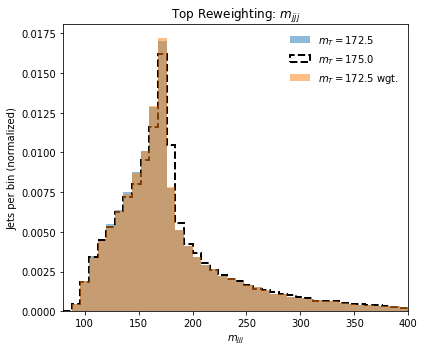

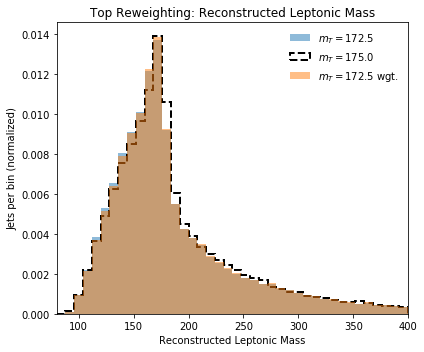

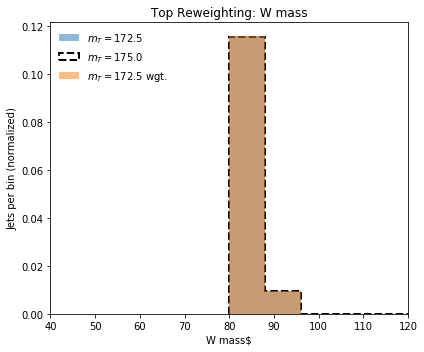

Iteration:  30
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5477 - acc: 0.7892 - val_loss: 0.5108 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5133 - acc: 0.7932 - val_loss: 0.5112 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5123 - acc: 0.7932 - val_loss: 0.5099 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5116 - acc: 0.7932 - val_loss: 0.5092 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5096 - val_acc: 0.7942
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5164 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

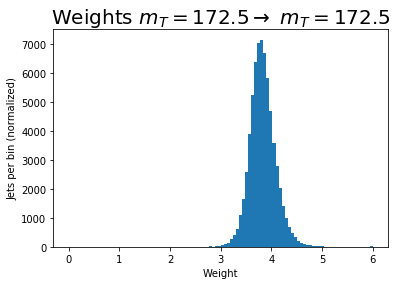

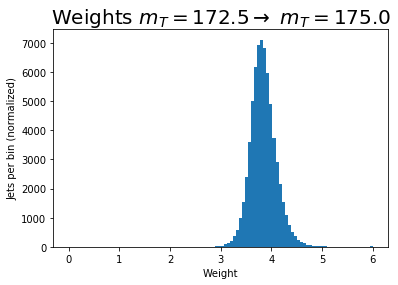

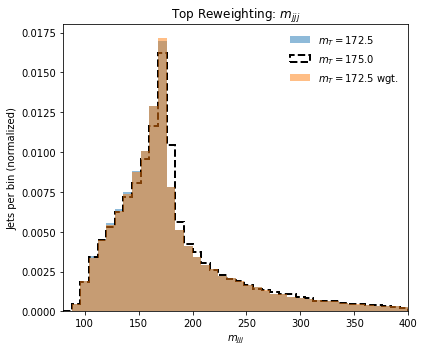

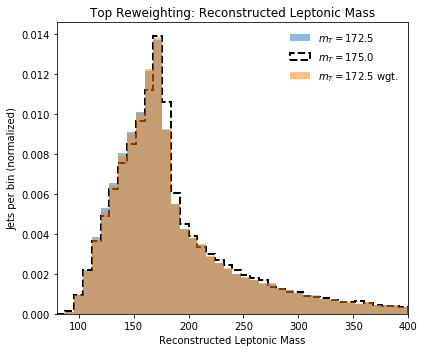

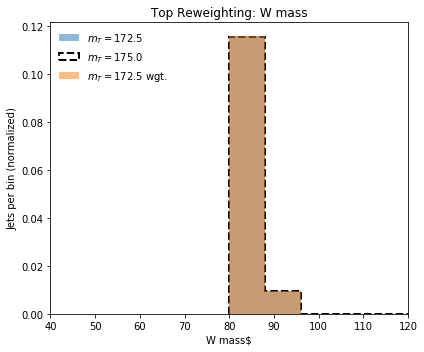

Iteration:  31
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5231 - acc: 0.7916 - val_loss: 0.5187 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5131 - acc: 0.7932 - val_loss: 0.5101 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5121 - acc: 0.7932 - val_loss: 0.5098 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5113 - acc: 0.7932 - val_loss: 0.5093 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5085 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5134 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

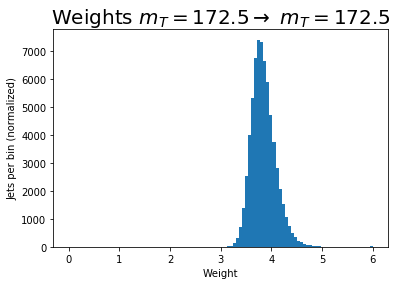

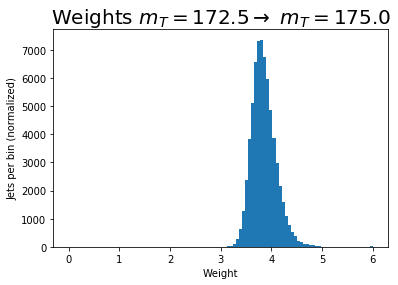

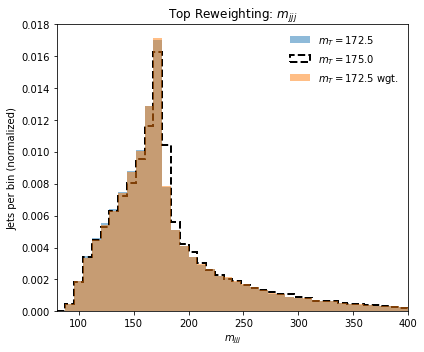

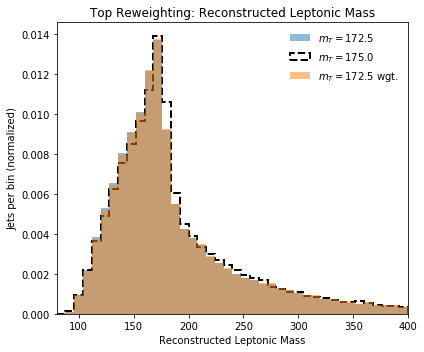

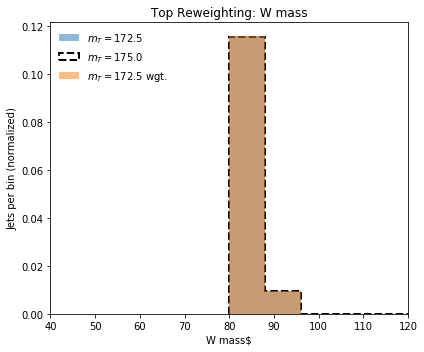

Iteration:  32
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5416 - acc: 0.7893 - val_loss: 0.5193 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5142 - acc: 0.7932 - val_loss: 0.5179 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5125 - acc: 0.7932 - val_loss: 0.5094 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5097 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5113 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7942
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

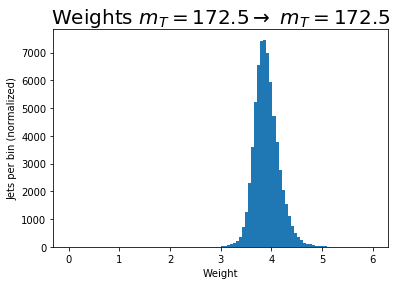

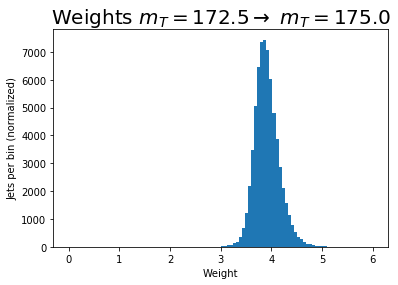

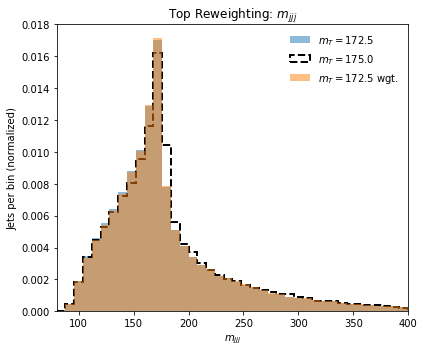

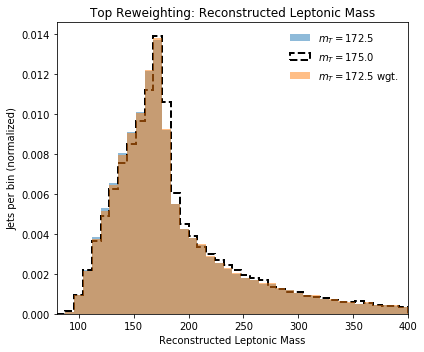

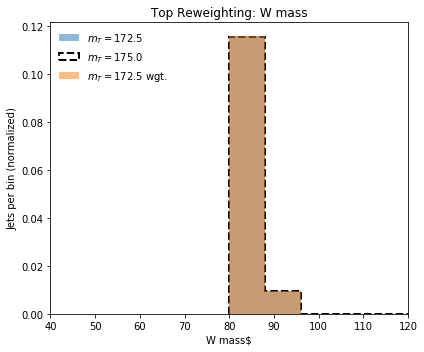

Iteration:  33
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5372 - acc: 0.7899 - val_loss: 0.5302 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5155 - acc: 0.7932 - val_loss: 0.5139 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5140 - acc: 0.7932 - val_loss: 0.5112 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5125 - acc: 0.7932 - val_loss: 0.5176 - val_acc: 0.7942
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

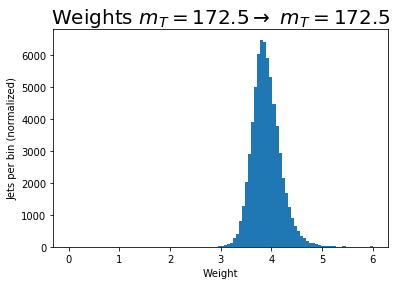

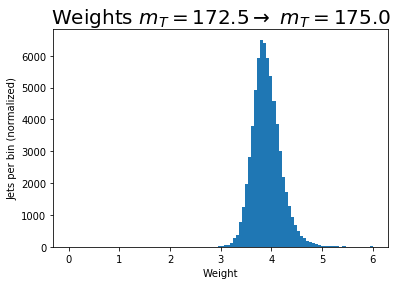

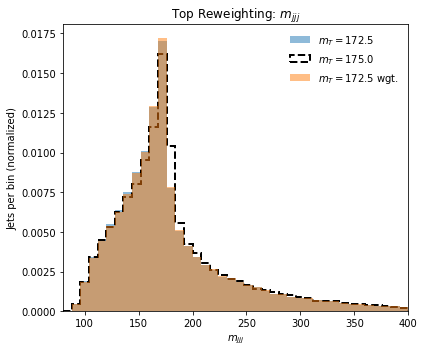

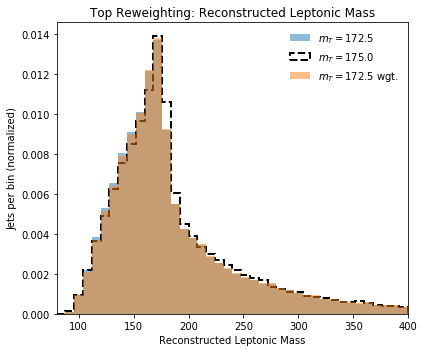

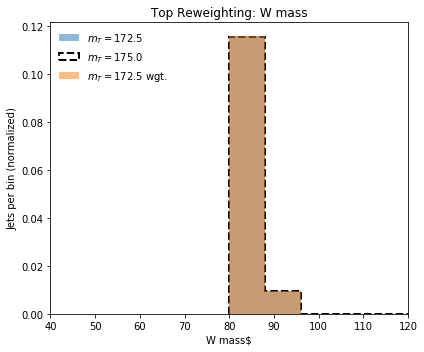

Iteration:  34
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5419 - acc: 0.7896 - val_loss: 0.5111 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5125 - acc: 0.7932 - val_loss: 0.5097 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5117 - acc: 0.7932 - val_loss: 0.5100 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5090 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5119 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5106 - acc: 0.7932 - val_loss: 0.5098 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/st

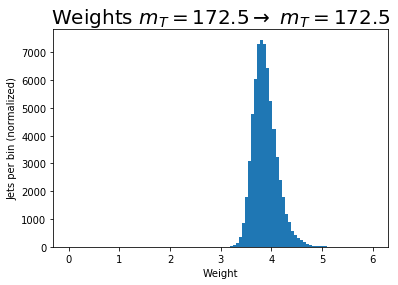

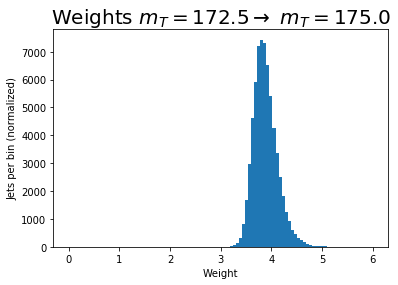

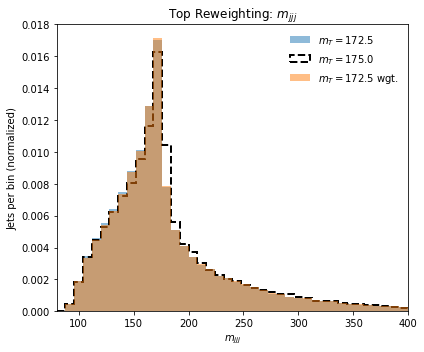

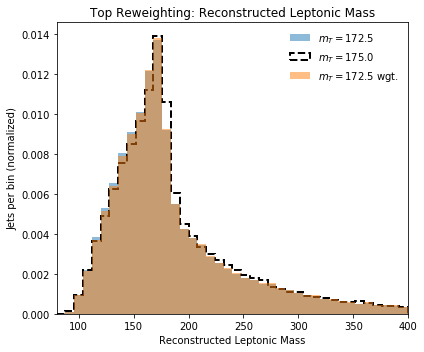

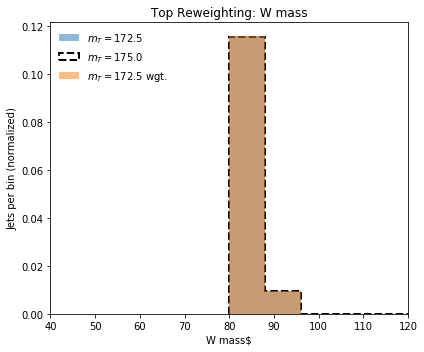

Iteration:  35
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5223 - acc: 0.7918 - val_loss: 0.5105 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5125 - acc: 0.7932 - val_loss: 0.5098 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5118 - acc: 0.7932 - val_loss: 0.5099 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5099 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5093 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5103 - acc: 0.7932 - val_loss: 0.5086 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

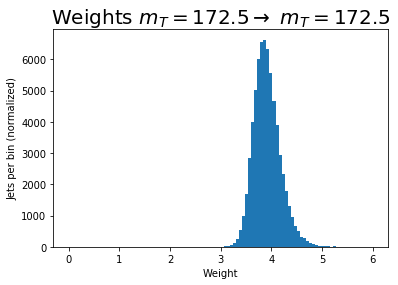

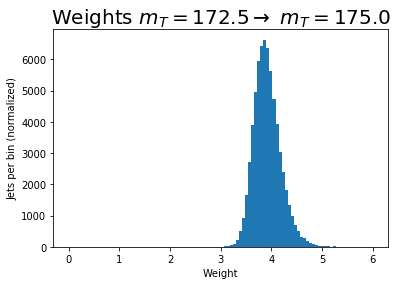

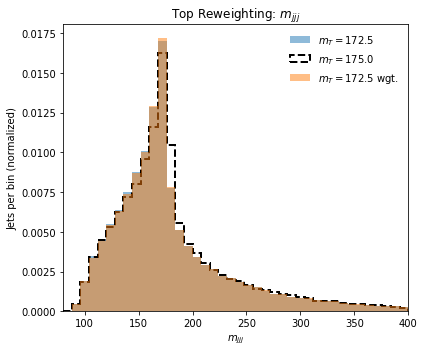

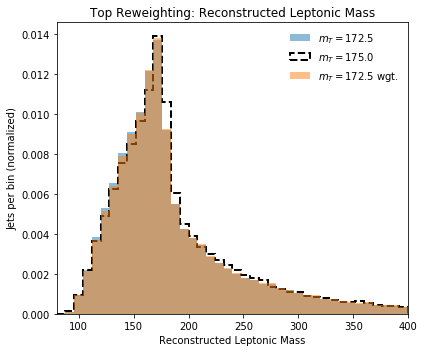

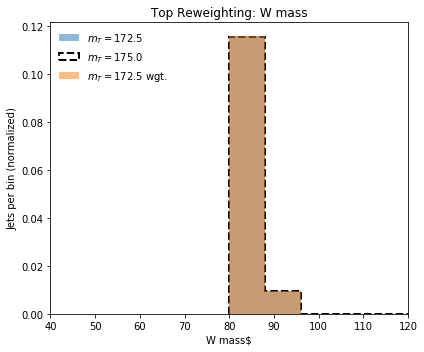

Iteration:  36
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5458 - acc: 0.7893 - val_loss: 0.5117 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5132 - acc: 0.7932 - val_loss: 0.5115 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5121 - acc: 0.7932 - val_loss: 0.5092 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5126 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5125 - val_acc: 0.7942
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

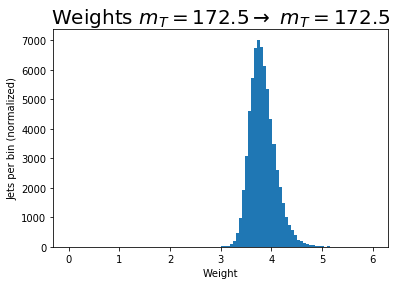

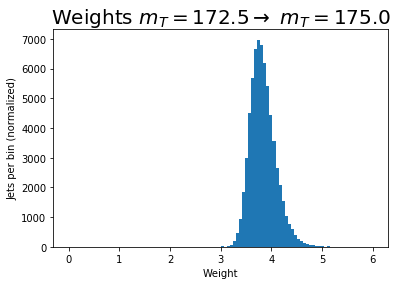

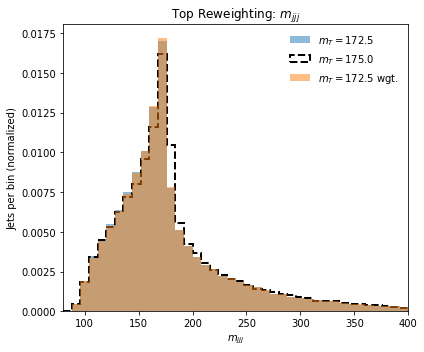

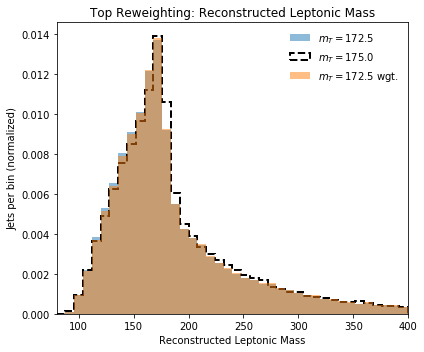

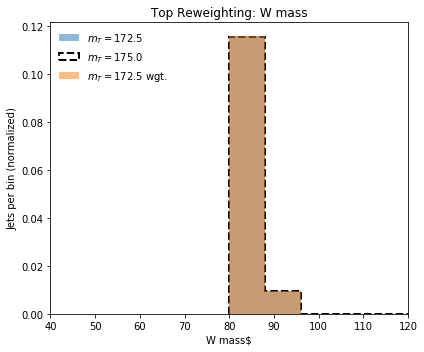

Iteration:  37
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5312 - acc: 0.7908 - val_loss: 0.5128 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5153 - acc: 0.7932 - val_loss: 0.5169 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5128 - acc: 0.7932 - val_loss: 0.5116 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5117 - acc: 0.7932 - val_loss: 0.5126 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5117 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5113 - acc: 0.7932 - val_loss: 0.5142 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

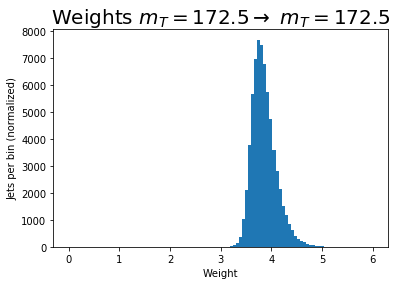

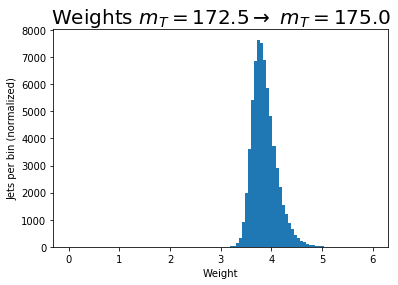

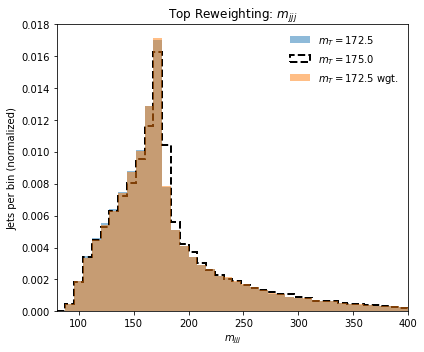

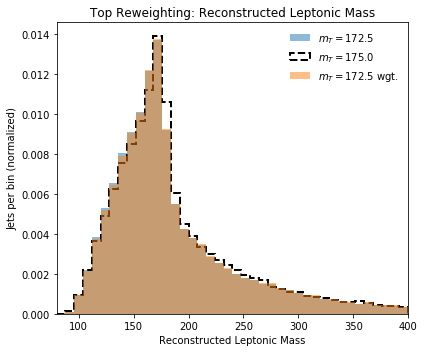

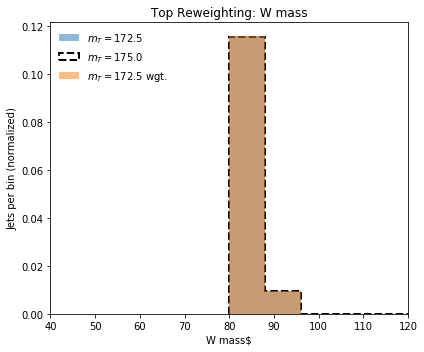

Iteration:  38
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5620 - acc: 0.7886 - val_loss: 0.5111 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5133 - acc: 0.7932 - val_loss: 0.5105 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5121 - acc: 0.7932 - val_loss: 0.5096 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5115 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7942
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5128 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

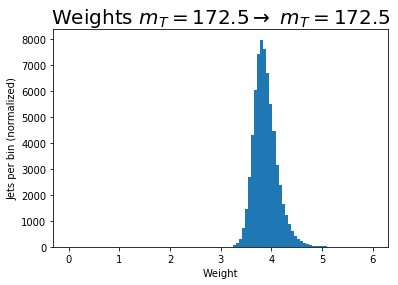

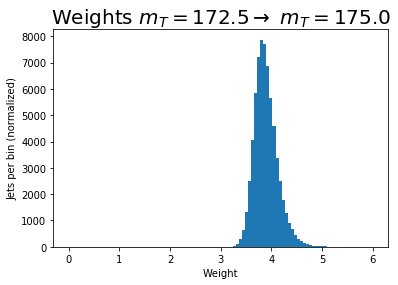

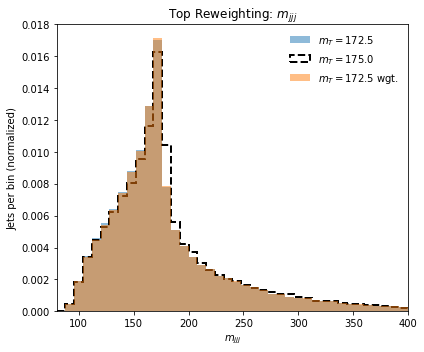

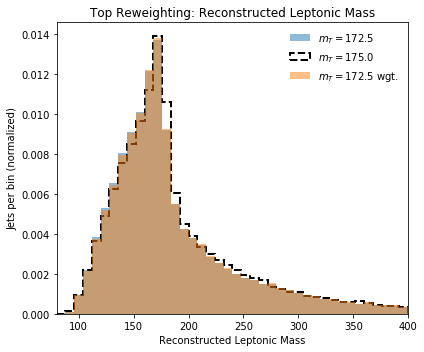

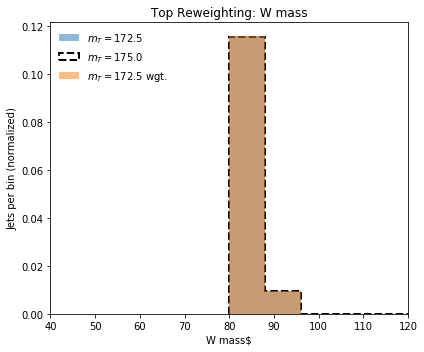

Iteration:  39
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5390 - acc: 0.7898 - val_loss: 0.5106 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5129 - acc: 0.7932 - val_loss: 0.5102 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5093 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5100 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5085 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

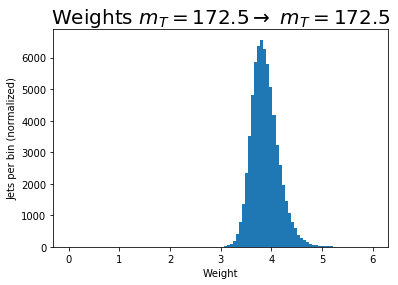

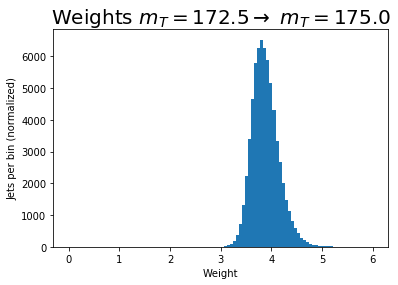

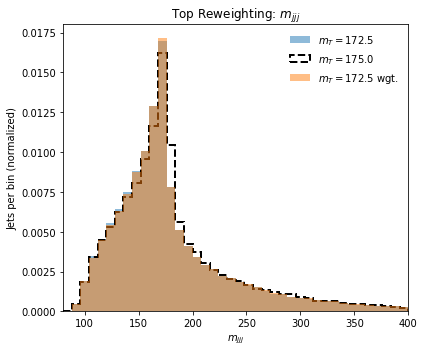

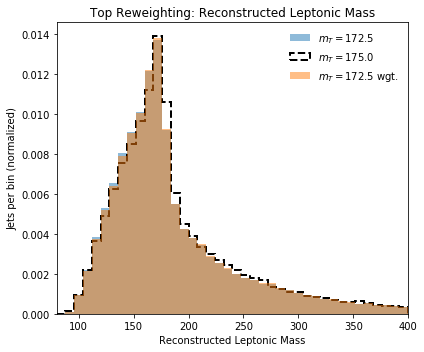

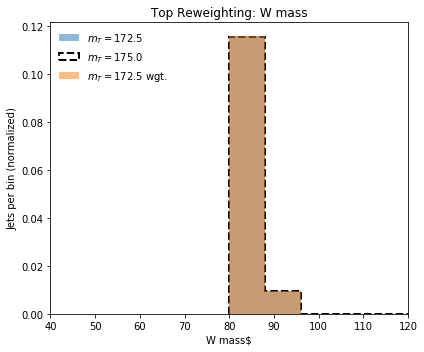

Iteration:  40
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5193 - acc: 0.7920 - val_loss: 0.5148 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5122 - acc: 0.7932 - val_loss: 0.5110 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5113 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5086 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5104 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

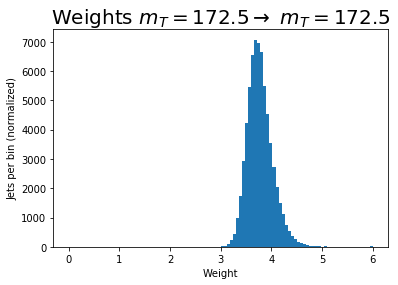

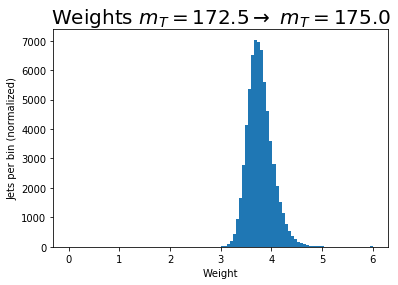

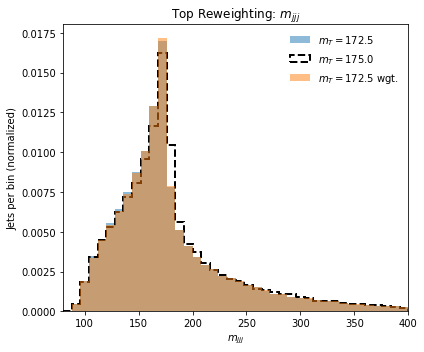

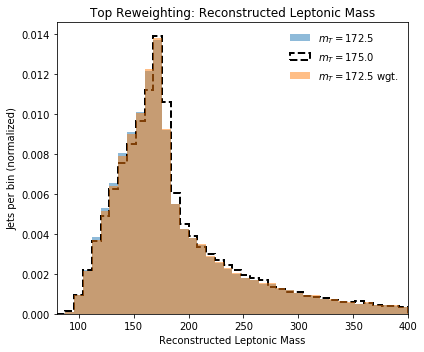

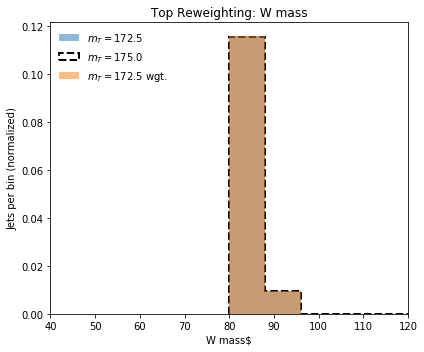

Iteration:  41
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5619 - acc: 0.7884 - val_loss: 0.5170 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5141 - acc: 0.7932 - val_loss: 0.5132 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5128 - acc: 0.7932 - val_loss: 0.5182 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5121 - acc: 0.7932 - val_loss: 0.5092 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5121 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5096 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/st

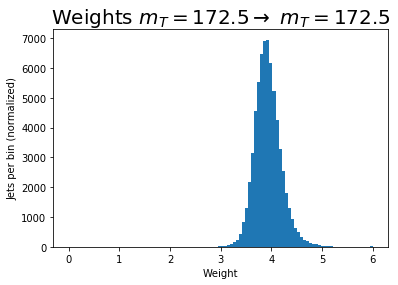

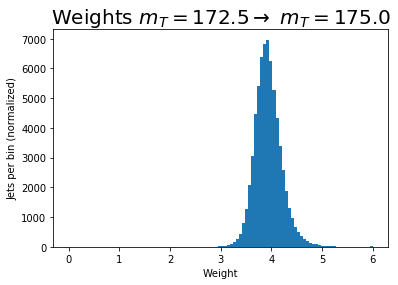

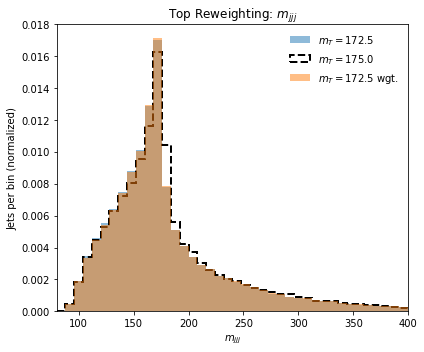

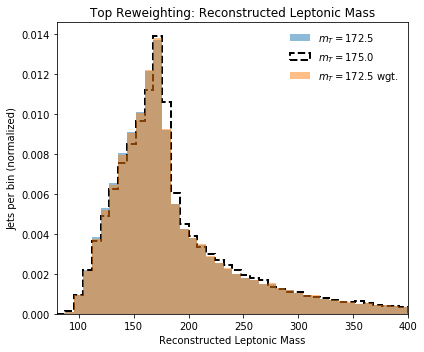

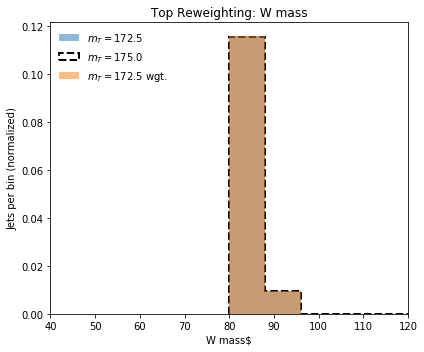

Iteration:  42
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5200 - acc: 0.7922 - val_loss: 0.5102 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5129 - acc: 0.7932 - val_loss: 0.5099 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5108 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 18us/st

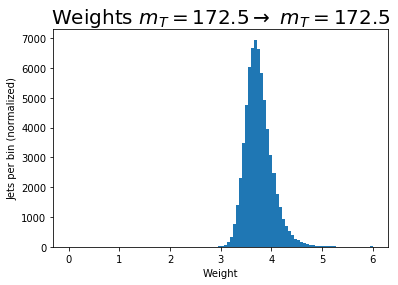

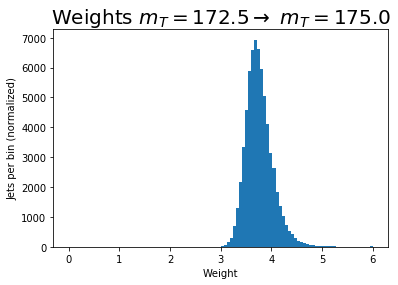

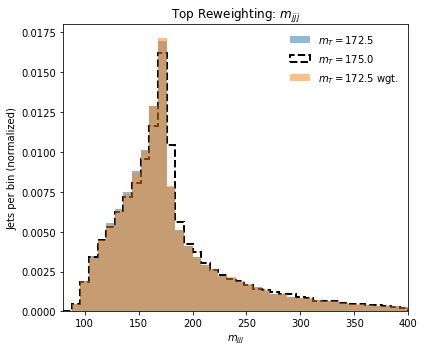

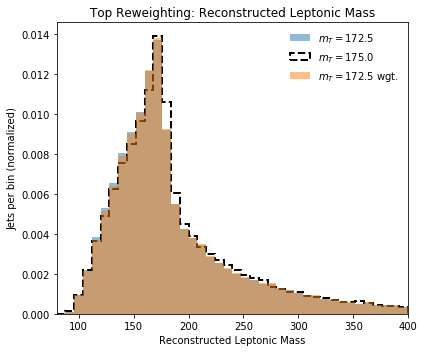

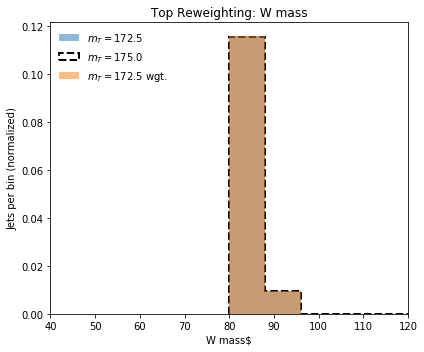

Iteration:  43
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5849 - acc: 0.7874 - val_loss: 0.5148 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5132 - acc: 0.7932 - val_loss: 0.5110 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5123 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5115 - acc: 0.7932 - val_loss: 0.5127 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5097 - val_acc: 0.7942
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

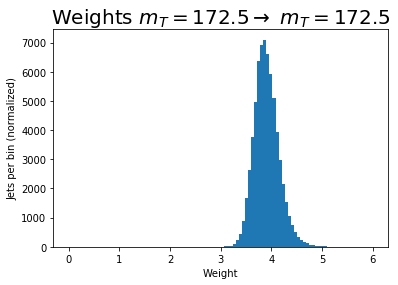

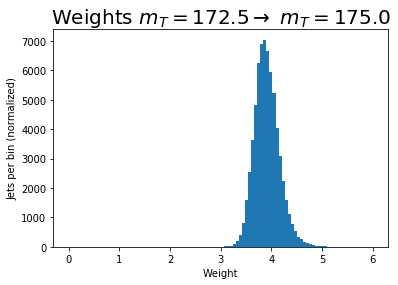

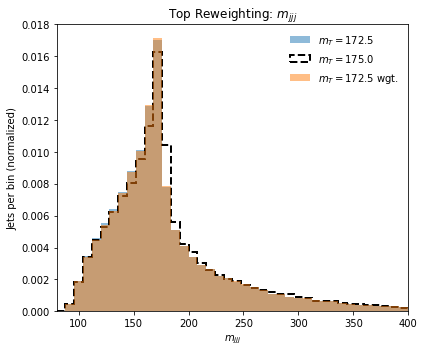

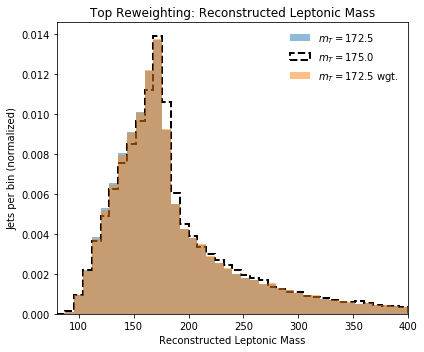

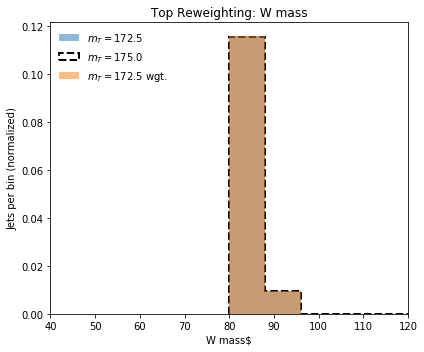

Iteration:  44
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5283 - acc: 0.7909 - val_loss: 0.5114 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5142 - acc: 0.7932 - val_loss: 0.5128 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5125 - acc: 0.7932 - val_loss: 0.5104 - val_acc: 0.7942
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5114 - acc: 0.7932 - val_loss: 0.5096 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5098 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5123 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/st

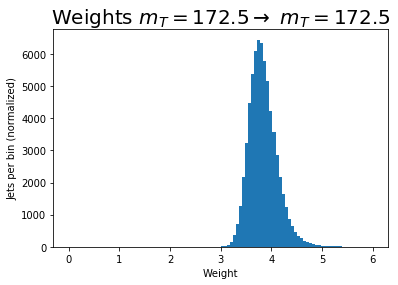

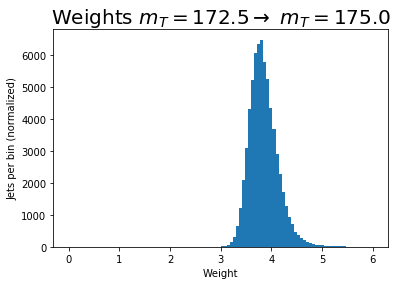

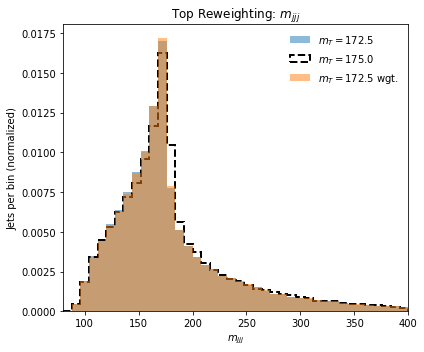

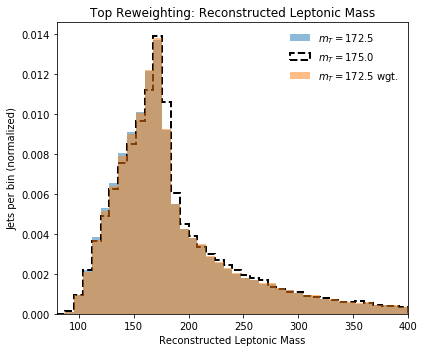

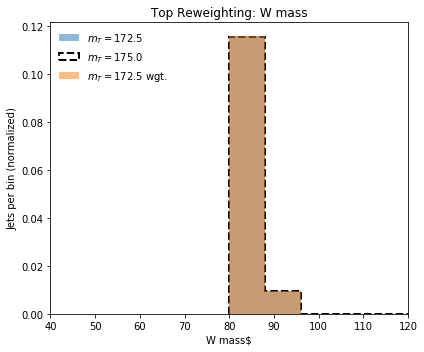

Iteration:  45
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5369 - acc: 0.7900 - val_loss: 0.5112 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5147 - acc: 0.7932 - val_loss: 0.5119 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5129 - acc: 0.7932 - val_loss: 0.5112 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5104 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5086 - val_acc: 0.7942
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

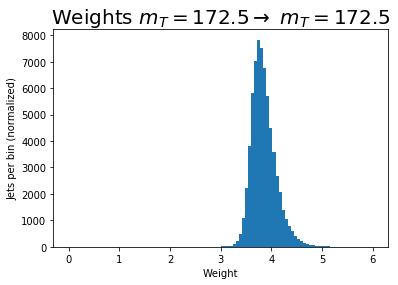

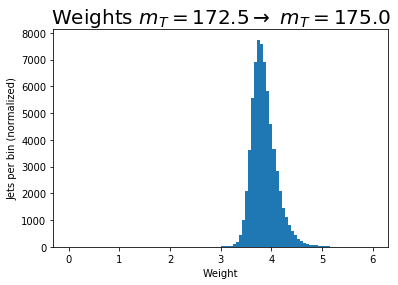

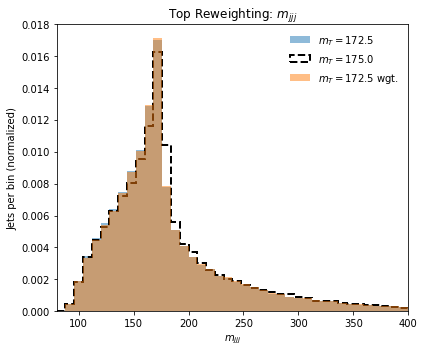

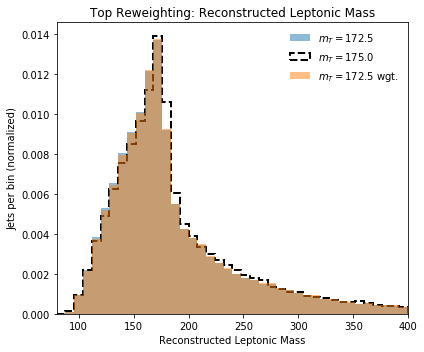

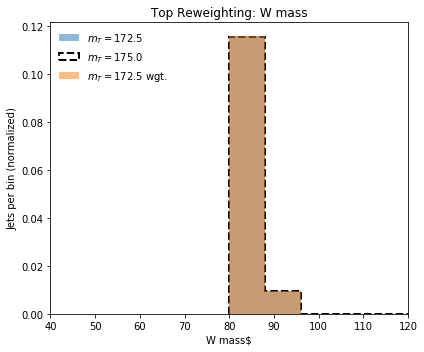

Iteration:  46
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5216 - acc: 0.7917 - val_loss: 0.5112 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5138 - acc: 0.7932 - val_loss: 0.5099 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5098 - val_acc: 0.7942
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5115 - acc: 0.7932 - val_loss: 0.5136 - val_acc: 0.7942
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5112 - acc: 0.7932 - val_loss: 0.5133 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

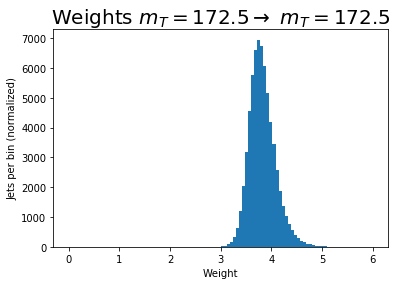

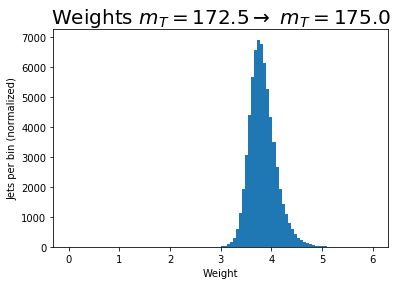

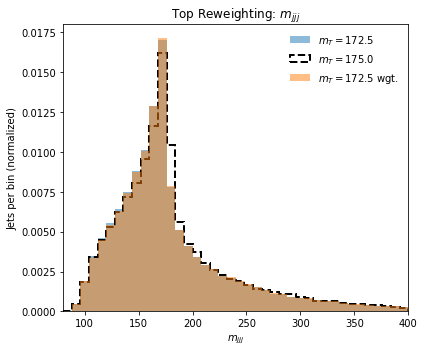

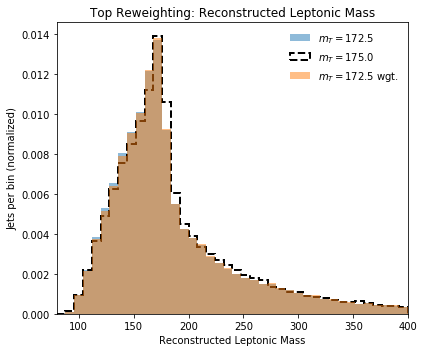

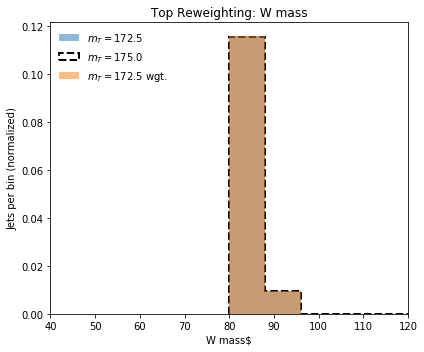

Iteration:  47
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5191 - acc: 0.7920 - val_loss: 0.5100 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5124 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5117 - acc: 0.7932 - val_loss: 0.5092 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5116 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5088 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5104 - acc: 0.7932 - val_loss: 0.5130 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

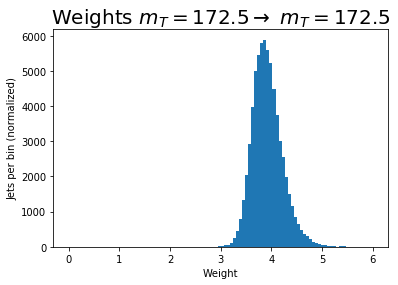

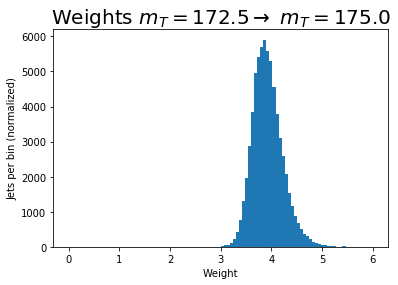

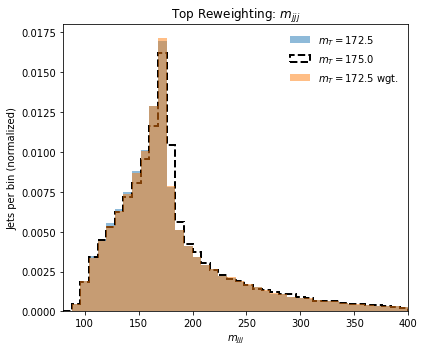

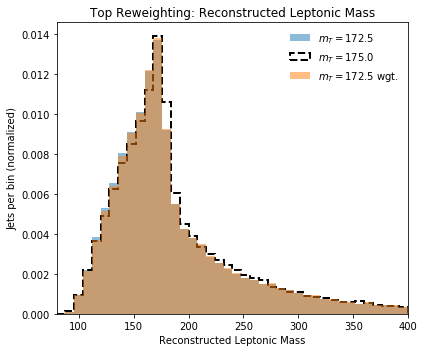

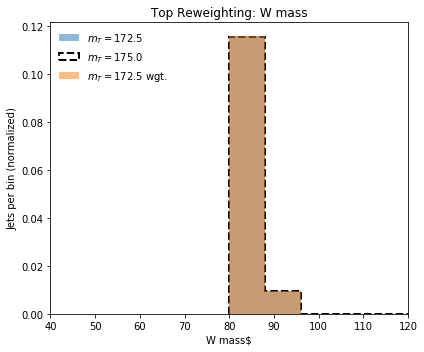

Iteration:  48
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5207 - acc: 0.7919 - val_loss: 0.5106 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5130 - acc: 0.7932 - val_loss: 0.5099 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5190 - val_acc: 0.7942
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5114 - acc: 0.7932 - val_loss: 0.5100 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5090 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5085 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/st

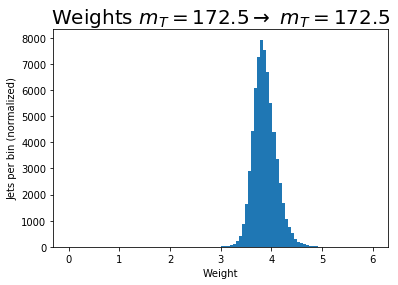

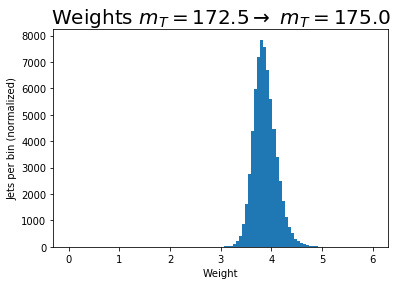

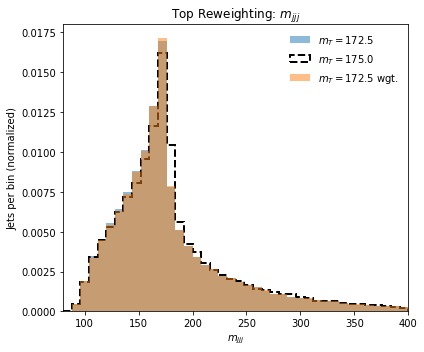

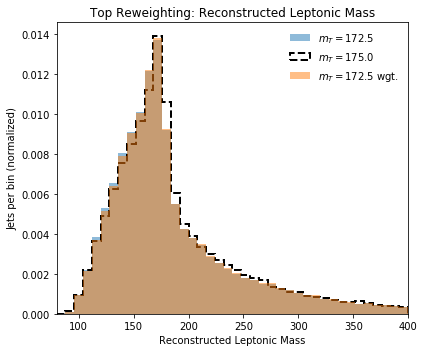

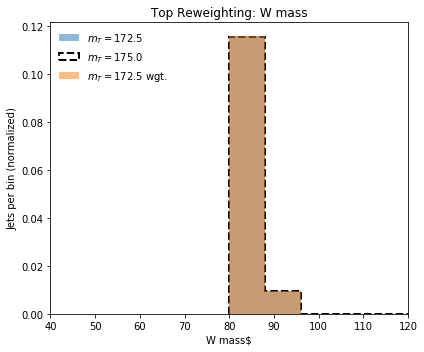

Iteration:  49
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5341 - acc: 0.7906 - val_loss: 0.5147 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5146 - acc: 0.7932 - val_loss: 0.5104 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5134 - acc: 0.7932 - val_loss: 0.5182 - val_acc: 0.7942
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5124 - acc: 0.7932 - val_loss: 0.5126 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5115 - acc: 0.7932 - val_loss: 0.5097 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

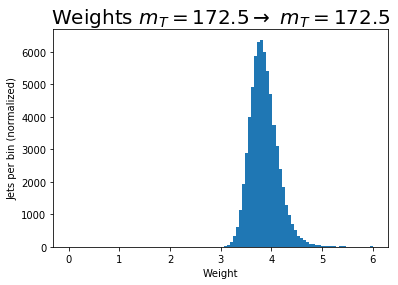

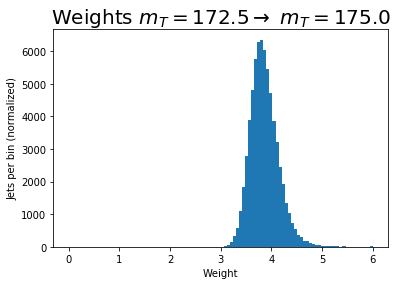

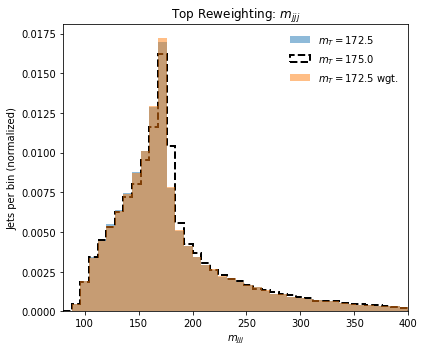

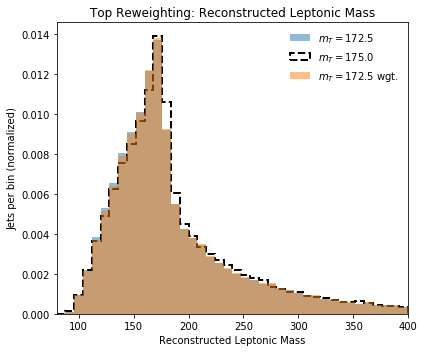

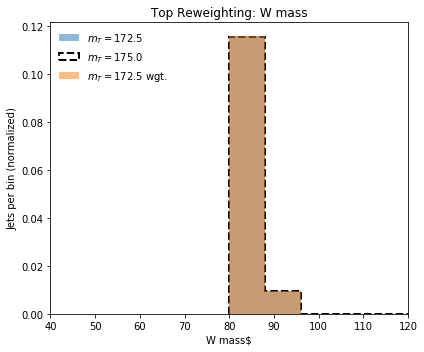

Iteration:  50
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5245 - acc: 0.7913 - val_loss: 0.5136 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5133 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5116 - acc: 0.7932 - val_loss: 0.5103 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5094 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5107 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5103 - acc: 0.7932 - val_loss: 0.5090 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

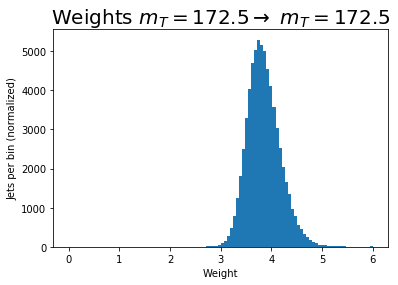

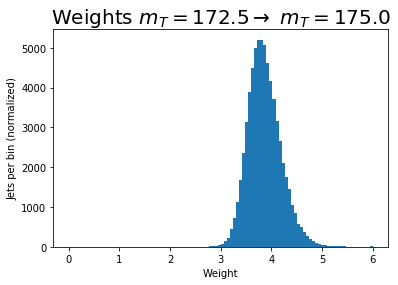

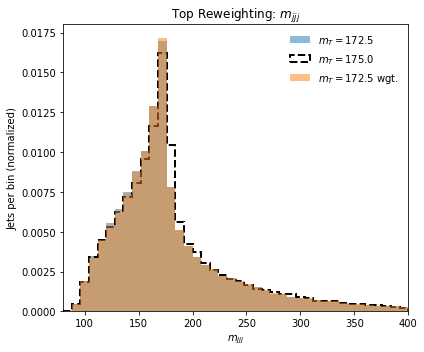

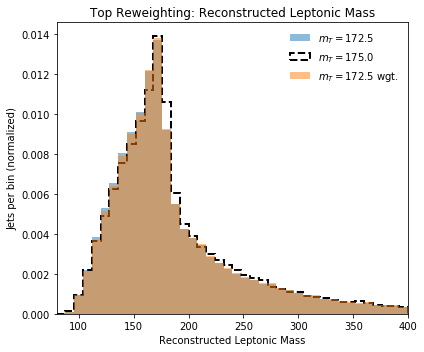

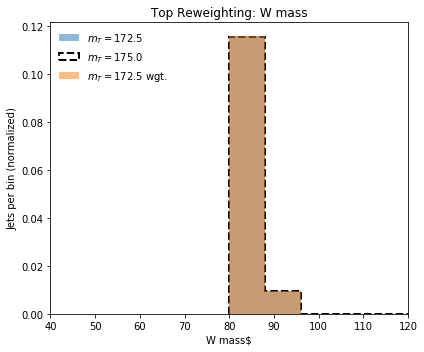

Iteration:  51
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5241 - acc: 0.7918 - val_loss: 0.5113 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5136 - acc: 0.7932 - val_loss: 0.5147 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5123 - acc: 0.7932 - val_loss: 0.5132 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5115 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

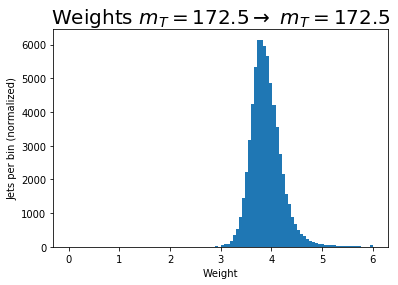

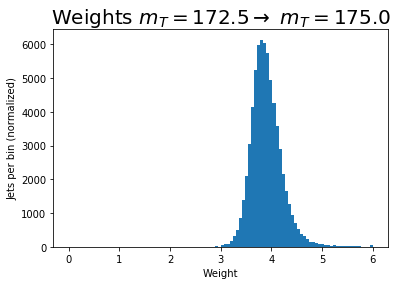

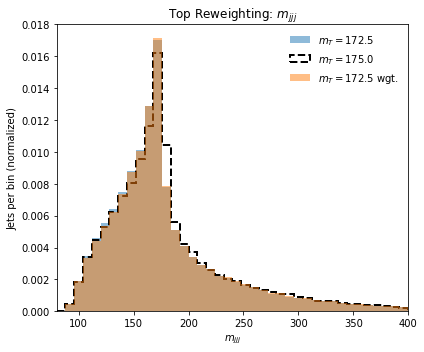

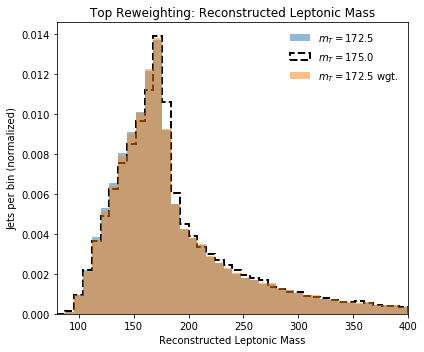

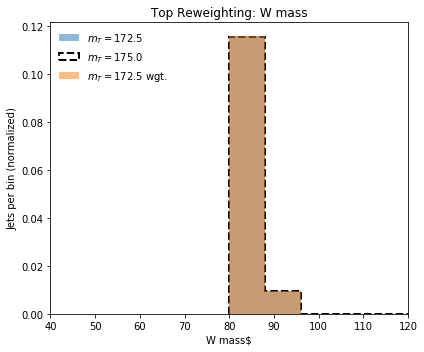

Iteration:  52
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5328 - acc: 0.7901 - val_loss: 0.5132 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5140 - acc: 0.7932 - val_loss: 0.5103 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5124 - acc: 0.7932 - val_loss: 0.5112 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5118 - acc: 0.7932 - val_loss: 0.5122 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5094 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

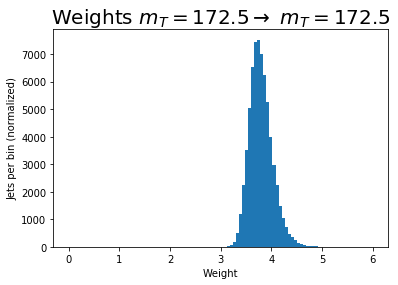

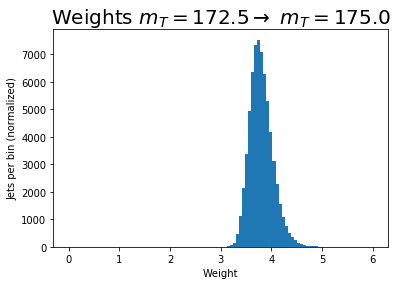

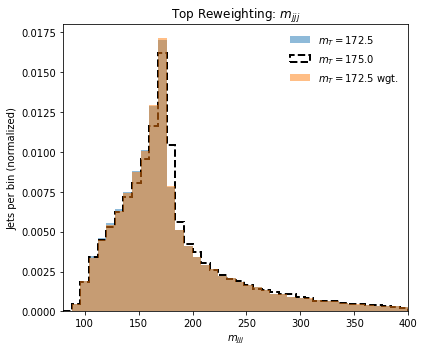

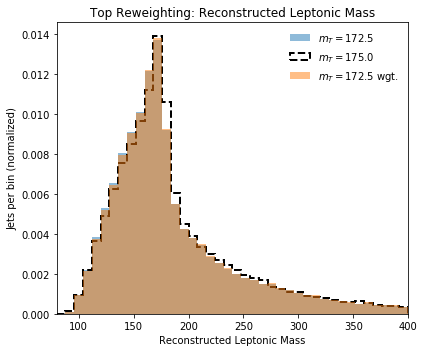

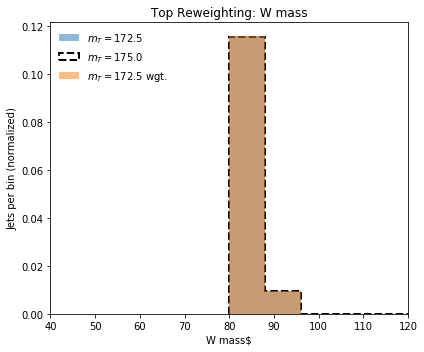

Iteration:  53
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5184 - acc: 0.7922 - val_loss: 0.5132 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5125 - acc: 0.7932 - val_loss: 0.5099 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5113 - acc: 0.7932 - val_loss: 0.5090 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5104 - acc: 0.7932 - val_loss: 0.5092 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5104 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

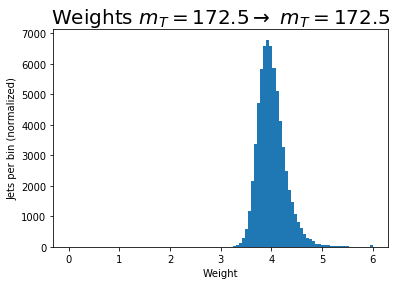

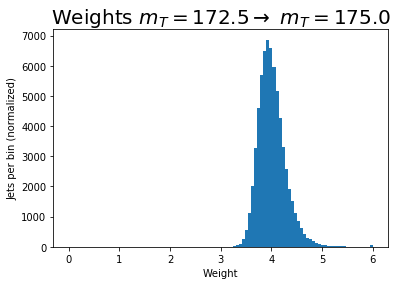

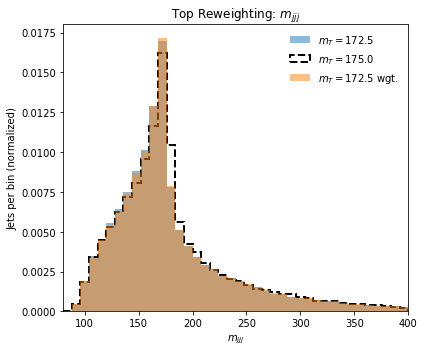

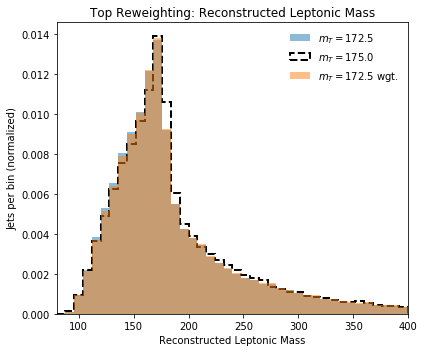

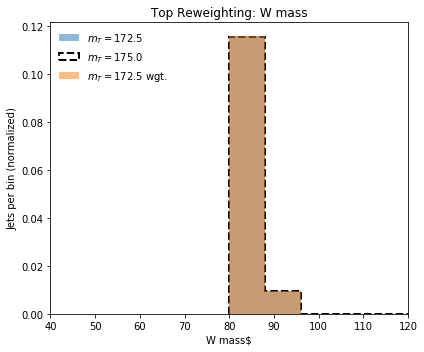

Iteration:  54
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5266 - acc: 0.7910 - val_loss: 0.5109 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5133 - acc: 0.7932 - val_loss: 0.5100 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5121 - acc: 0.7932 - val_loss: 0.5130 - val_acc: 0.7942
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5118 - acc: 0.7932 - val_loss: 0.5118 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5099 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5090 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

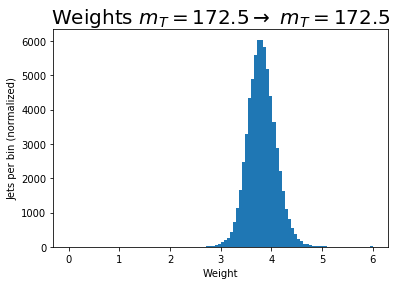

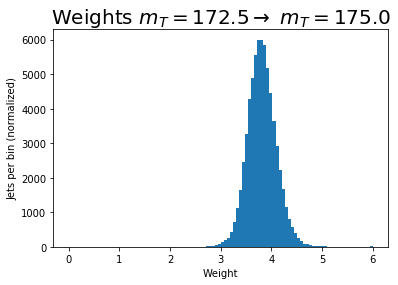

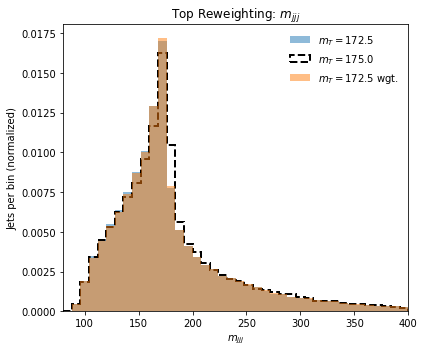

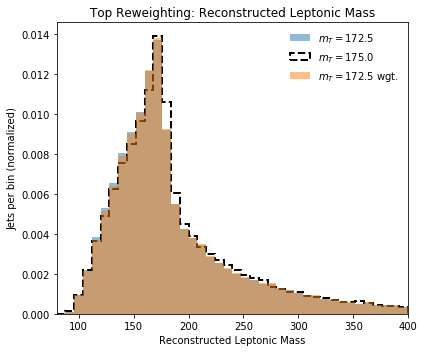

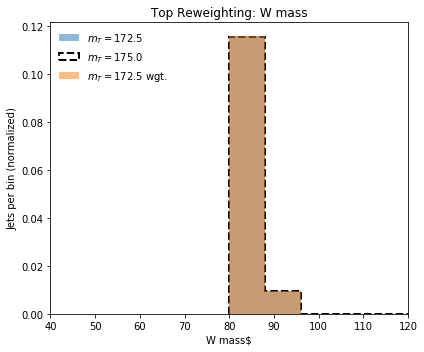

Iteration:  55
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5566 - acc: 0.7887 - val_loss: 0.5128 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5140 - acc: 0.7932 - val_loss: 0.5116 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5123 - acc: 0.7932 - val_loss: 0.5136 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5116 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5114 - acc: 0.7932 - val_loss: 0.5097 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5139 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

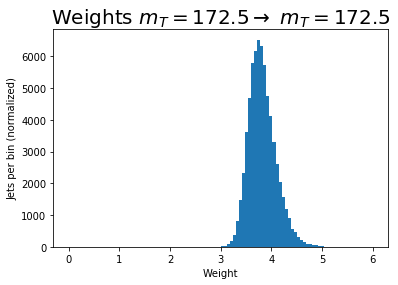

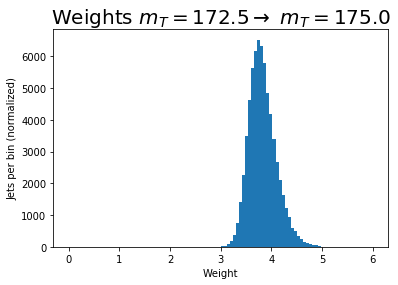

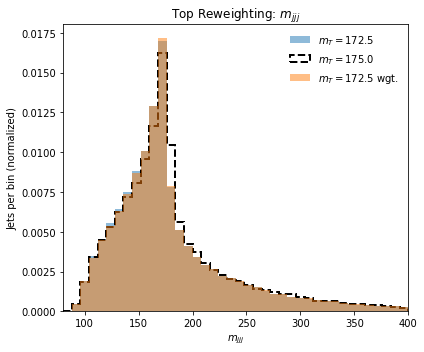

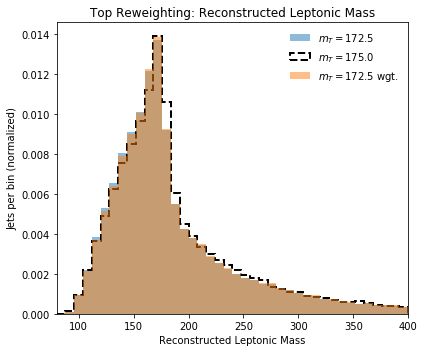

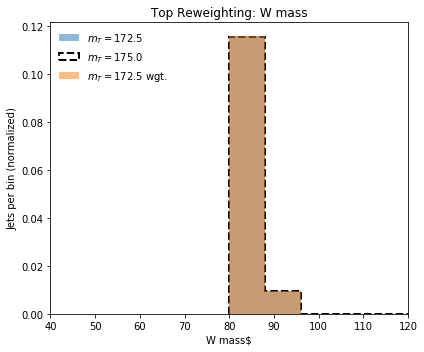

Iteration:  56
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5231 - acc: 0.7914 - val_loss: 0.5112 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5133 - acc: 0.7932 - val_loss: 0.5106 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5119 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7942
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5108 - val_acc: 0.7942
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5086 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5086 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

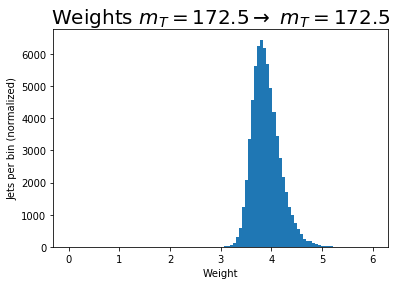

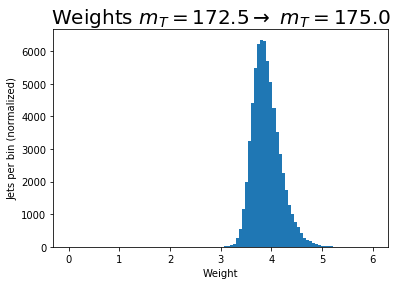

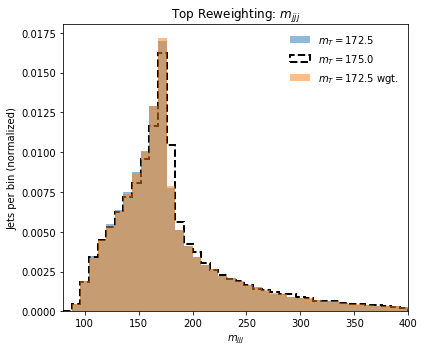

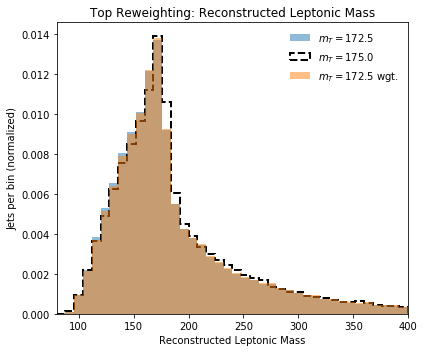

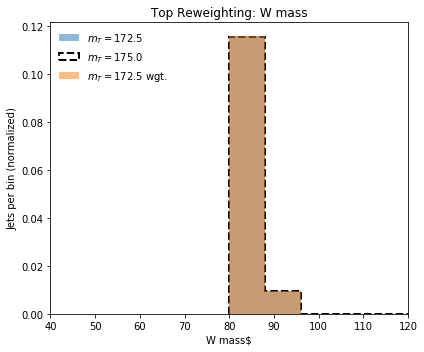

Iteration:  57
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5179 - acc: 0.7926 - val_loss: 0.5118 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5120 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5116 - acc: 0.7932 - val_loss: 0.5092 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5113 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5085 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5104 - acc: 0.7932 - val_loss: 0.5085 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

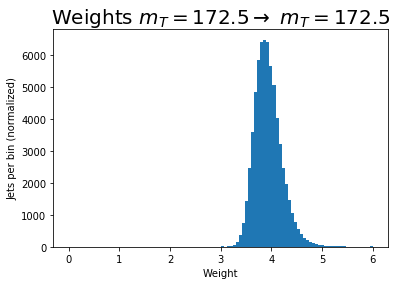

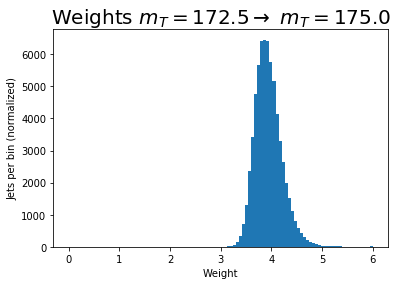

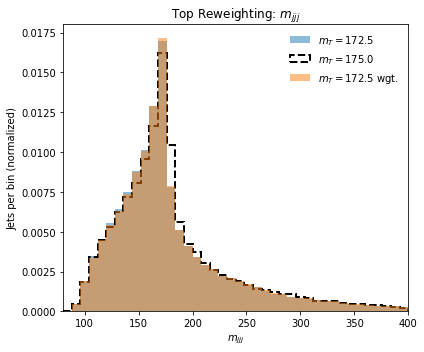

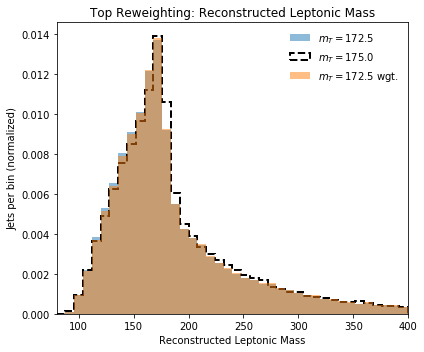

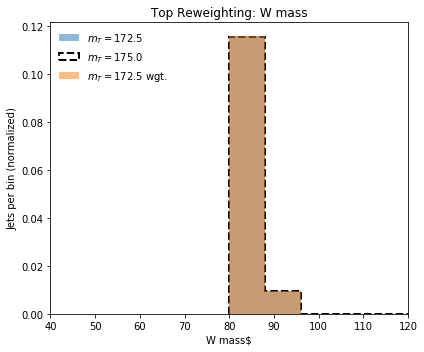

Iteration:  58
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5233 - acc: 0.7915 - val_loss: 0.5108 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5124 - acc: 0.7932 - val_loss: 0.5108 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5116 - acc: 0.7932 - val_loss: 0.5103 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5098 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5145 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5105 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

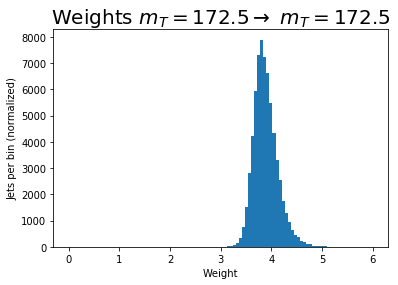

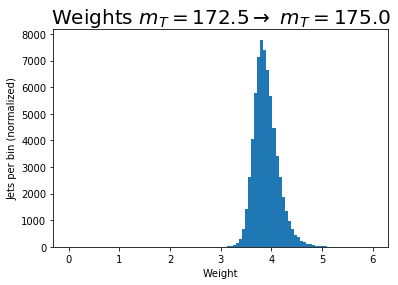

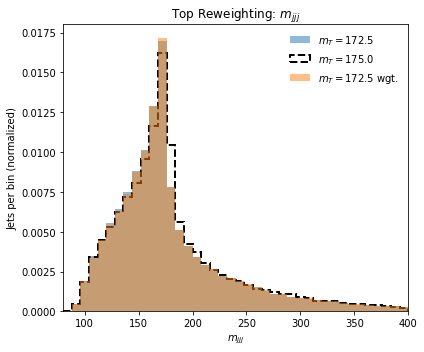

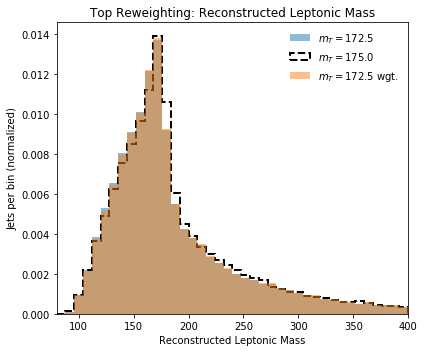

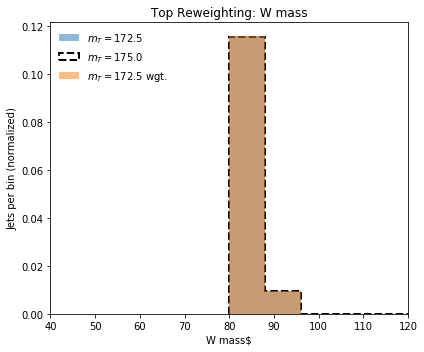

Iteration:  59
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5256 - acc: 0.7914 - val_loss: 0.5149 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5154 - acc: 0.7932 - val_loss: 0.5118 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5129 - acc: 0.7932 - val_loss: 0.5201 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5124 - acc: 0.7932 - val_loss: 0.5096 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5116 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5126 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

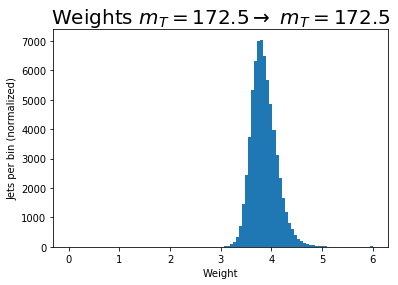

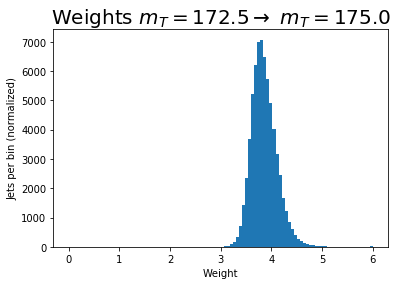

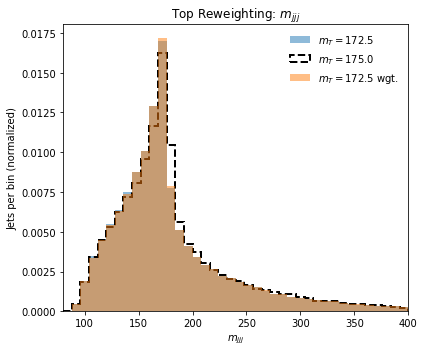

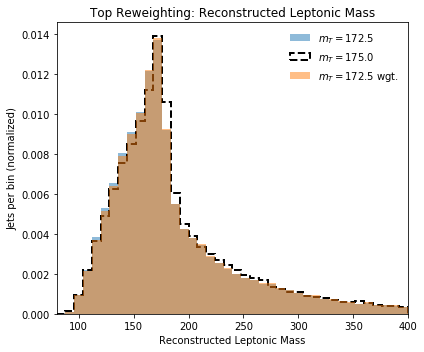

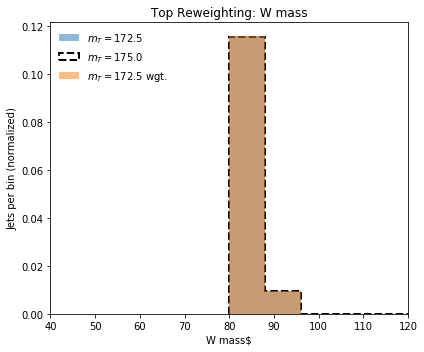

Iteration:  60
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5323 - acc: 0.7902 - val_loss: 0.5106 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5131 - acc: 0.7932 - val_loss: 0.5094 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5121 - acc: 0.7932 - val_loss: 0.5098 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5110 - acc: 0.7932 - val_loss: 0.5101 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5106 - acc: 0.7932 - val_loss: 0.5111 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

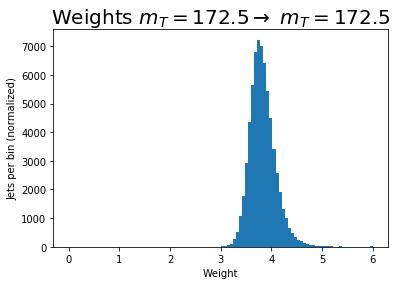

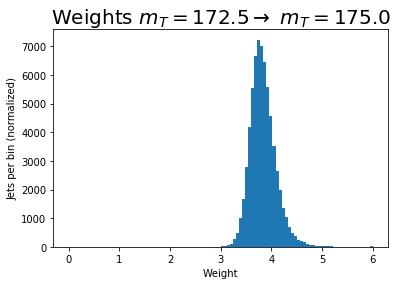

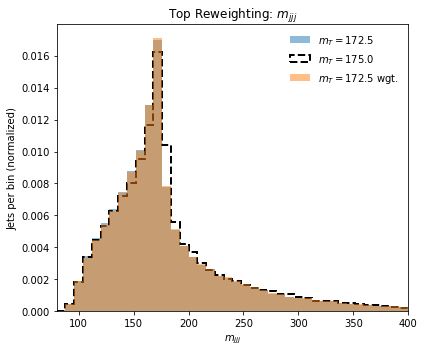

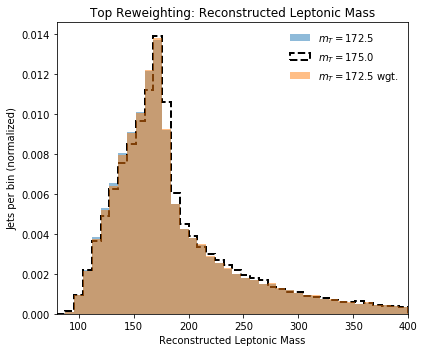

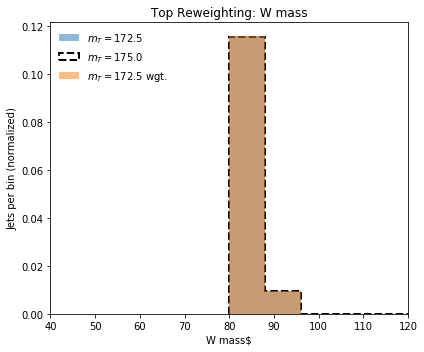

Iteration:  61
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5223 - acc: 0.7917 - val_loss: 0.5119 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5132 - acc: 0.7932 - val_loss: 0.5128 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5119 - acc: 0.7932 - val_loss: 0.5090 - val_acc: 0.7942
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5098 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5097 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5104 - acc: 0.7932 - val_loss: 0.5093 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/st

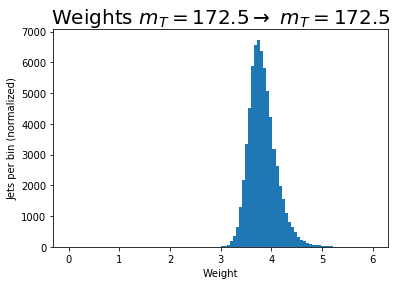

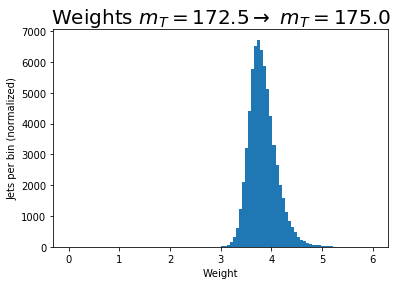

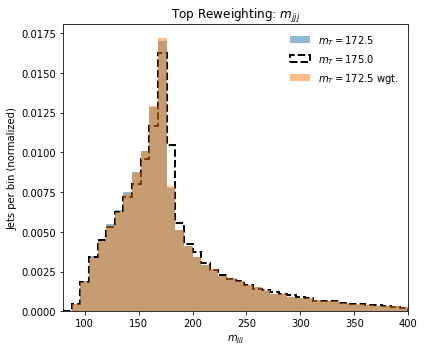

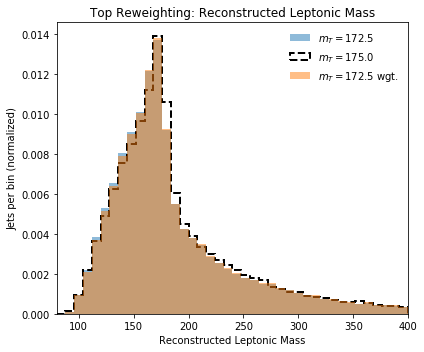

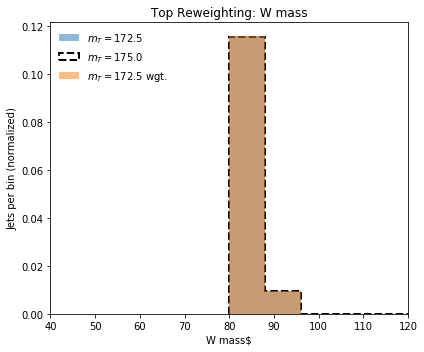

Iteration:  62
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5241 - acc: 0.7914 - val_loss: 0.5124 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5141 - acc: 0.7932 - val_loss: 0.5101 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5127 - acc: 0.7932 - val_loss: 0.5101 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5113 - acc: 0.7932 - val_loss: 0.5097 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5111 - acc: 0.7932 - val_loss: 0.5101 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5109 - acc: 0.7932 - val_loss: 0.5094 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/st

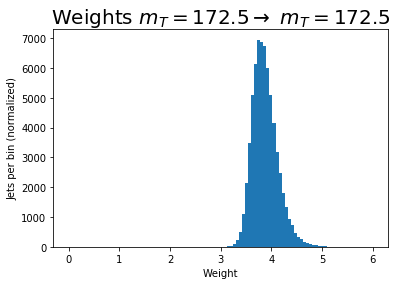

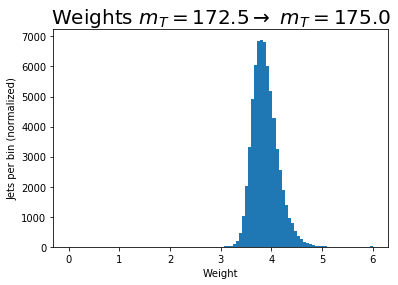

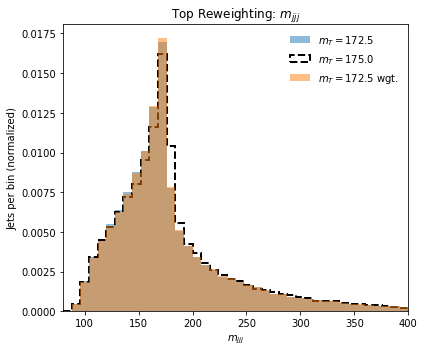

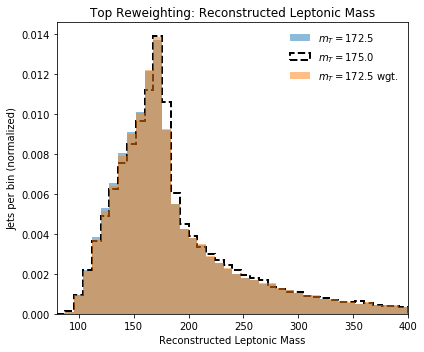

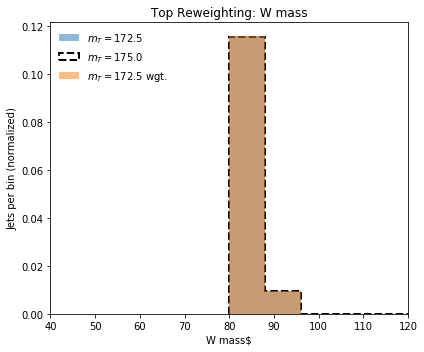

Iteration:  63
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5207 - acc: 0.7920 - val_loss: 0.5135 - val_acc: 0.7943
Epoch 2/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5132 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5118 - acc: 0.7932 - val_loss: 0.5093 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5113 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5106 - acc: 0.7932 - val_loss: 0.5087 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 22s 19us/st

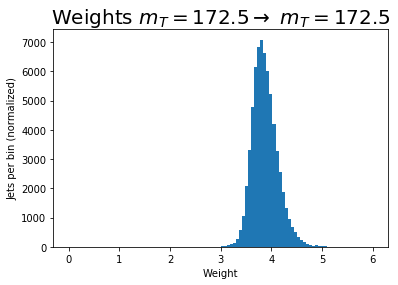

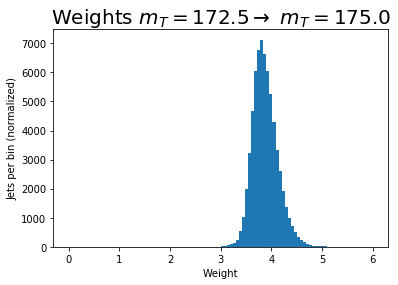

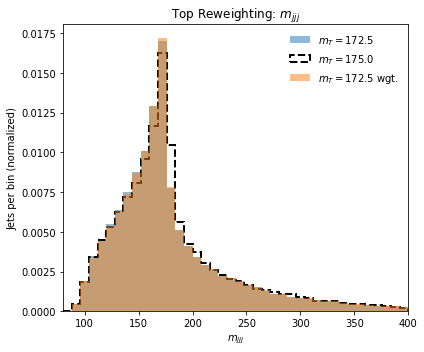

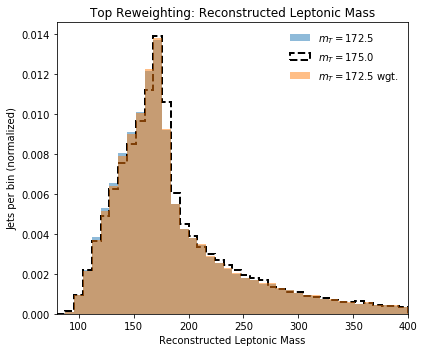

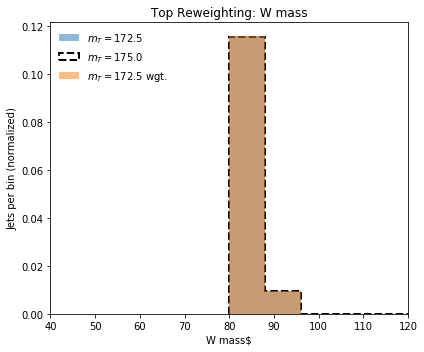

Iteration:  64
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5485 - acc: 0.7893 - val_loss: 0.5127 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5143 - acc: 0.7932 - val_loss: 0.5116 - val_acc: 0.7943
Epoch 3/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5128 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5122 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5114 - acc: 0.7932 - val_loss: 0.5089 - val_acc: 0.7943
Epoch 6/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5108 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 19us/st

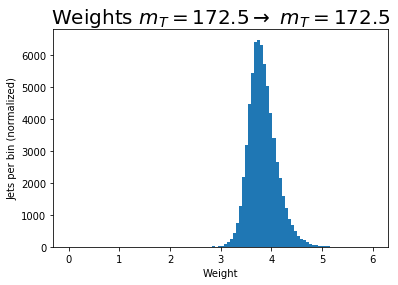

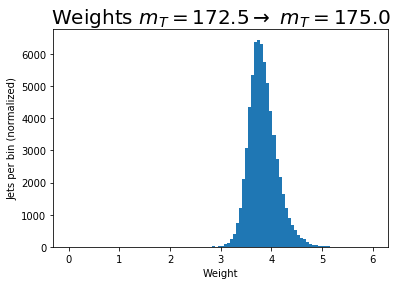

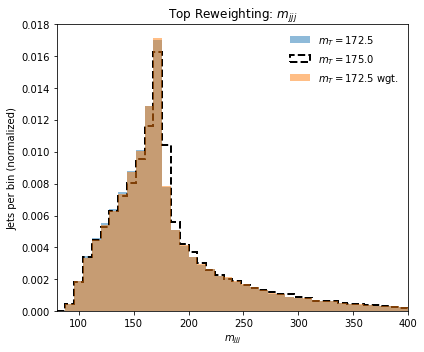

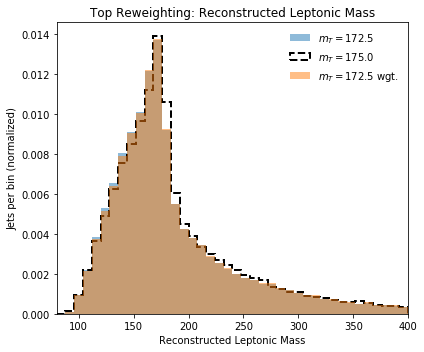

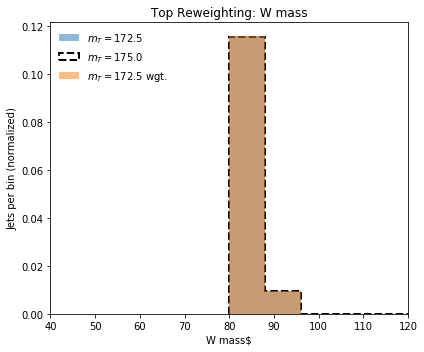

Iteration:  65
Train on 1158322 samples, validate on 128702 samples
Epoch 1/100
1158322/1158322 [==============================] - 22s 19us/step - loss: 0.5263 - acc: 0.7906 - val_loss: 0.5111 - val_acc: 0.7942
Epoch 2/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5133 - acc: 0.7932 - val_loss: 0.5115 - val_acc: 0.7942
Epoch 3/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5127 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7942
Epoch 4/100
1158322/1158322 [==============================] - 21s 19us/step - loss: 0.5115 - acc: 0.7932 - val_loss: 0.5095 - val_acc: 0.7943
Epoch 5/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5114 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7942
Epoch 6/100
1158322/1158322 [==============================] - 21s 18us/step - loss: 0.5107 - acc: 0.7932 - val_loss: 0.5091 - val_acc: 0.7943
Epoch 7/100
1158322/1158322 [==============================] - 21s 18us/st

In [35]:
iterations = 100
for i in range(iterations):
    print("Iteration: ", i)

    K.clear_session()
    dctr = PFN(input_dim=6,
               Phi_sizes=Phi_sizes,
               F_sizes=F_sizes,
               summary=False)
    lr = 1e-4  #smaller learning rate yields better precision
    optimizer = keras.optimizers.Adam(lr=lr)
    dctr.model.compile(optimizer=optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
    history = dctr.fit(X_train,
                       Y_train,
                       epochs=100,
                       batch_size=1000,
                       validation_data=(X_val, Y_val),
                       verbose=1,
                       callbacks=[EarlyStopping])

    weights_0 = reweight(events = X0_test, param =172.5)

    weights_1 = reweight(events = X0_test, param =175.0)
    
    print(max(weights_0))
    print(max(1/weights_0))
    print(max(weights_1))
    print(max(1/weights_1))
    
    clip_val = 6
    bins = np.linspace(0, clip_val, 101)
    plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
    plt.xlabel("Weight")
    plt.ylabel('Jets per bin (normalized)')
    plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_0, fontsize = 20)
    plt.show()
    
    clip_val = 6
    bins = np.linspace(0, clip_val, 101)
    plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
    plt.xlabel("Weight")
    plt.ylabel('Jets per bin (normalized)')
    plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_1, fontsize = 20)
    plt.show()
    
    plt.figure(figsize=(6,5))
    plt.title("Top Reweighting: $m_{jjj}$")
    bins = np.linspace(80,400,41)
    hist0 = plt.hist(test_obs_0[:,0], bins = bins, label = label_0, **plot_style_1)
    hist1 = plt.hist(test_obs_1[:,0], bins = bins, label = label_1, **plot_style_0)
    hist2 = plt.hist(test_obs_0[:,0], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

    plt.xlabel('$m_{jjj}$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80,400])
    make_legend()
    #plt.savefig("Top Reweighting: m_{jjj} only.png")
    plt.show()
    
    plt.figure(figsize=(6,5))
    plt.title("Top Reweighting: Reconstructed Leptonic Mass")
    bins = np.linspace(80,400,41)
    hist0 = plt.hist(test_obs_0[:,1], bins = bins, label = label_0, **plot_style_1)
    hist1 = plt.hist(test_obs_1[:,1], bins = bins, label = label_1, **plot_style_0)
    hist2 = plt.hist(test_obs_0[:,1], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

    plt.xlabel('Reconstructed Leptonic Mass')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80,400])
    make_legend()
    #plt.savefig("Top Reweighting: m_{jjj} only.png")
    plt.show()
    
    plt.figure(figsize=(6,5))
    plt.title("Top Reweighting: W mass")
    bins = np.linspace(80,400,41)
    hist0 = plt.hist(test_obs_0[:,2], bins = bins, label = label_0, **plot_style_1)
    hist1 = plt.hist(test_obs_1[:,2], bins = bins, label = label_1, **plot_style_0)
    hist2 = plt.hist(test_obs_0[:,2], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

    plt.xlabel('W mass$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([40,120])
    make_legend()
    #plt.savefig("Top Reweighting: m_{jjj} only.png")
    plt.show() 